In [1]:
!pip install yfinance tensorflow ta gym textblob

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=93fd1ecb9ee59c5aca855e4b9d3a6e96a4aa3379b306dac9b38cdc7671a60c08
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [2]:
!pip install --upgrade yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.4/118.4 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.61
    Uninstalling yfinance-0.2.61:
      Successfully uninstalled yfinance-0.2.61


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Flatten, Conv1D, LSTM, Dropout, concatenate
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
import datetime
import ta
import gym
from gym import spaces
from sklearn.preprocessing import StandardScaler
import warnings
from tensorflow.keras.layers import GlobalAveragePooling1D
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

HMAX_NORMALIZE = 100
# initial amount of money we have in our account
INITIAL_ACCOUNT_BALANCE=1000000
# total number of stocks in our portfolio
STOCK_DIM = 10
# transaction fee: 1/1000 reasonable percentage
TRANSACTION_FEE_PERCENT = 0.001

In [4]:
class PositionTracker:
    """Tracks average cost basis for stock positions"""
    def __init__(self):
        self.total_shares = 0
        self.total_cost = 0

    def add_purchase(self, shares, price):
        """Add shares to position"""
        self.total_shares += shares
        self.total_cost += shares * price

    def reduce_position(self, shares):
        """Remove shares from position"""
        self.total_shares = max(0, self.total_shares - shares)

    def get_avg_cost(self):
        """Get average cost per share"""
        return self.total_cost / self.total_shares if self.total_shares > 0 else 0

In [5]:
class MultiStockTradingEnv(gym.Env):
    """
    Trading environment that handles multiple stocks simultaneously
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, stock_dfs, initial_balance=1000000, transaction_fee_percent=0.0001,
                window_size=20):
        super(MultiStockTradingEnv, self).__init__()

        self.stock_dfs = stock_dfs  # Dictionary of dataframes {symbol: dataframe}
        self.symbols = list(stock_dfs.keys())
        self.n_stocks = len(self.symbols)
        self.window_size = window_size
        self.initial_balance = initial_balance
        self.transaction_fee_percent = transaction_fee_percent

        # Find common dates across all stocks
        common_dates = None
        for symbol, df in stock_dfs.items():
            if common_dates is None:
                common_dates = set(df.index)
            else:
                common_dates = common_dates.intersection(set(df.index))

        self.common_dates = sorted(list(common_dates))
        print(f"Trading environment created with {len(self.common_dates)} common trading days")

        # Action space: For each stock: [no action, buy 25%, buy 50%, buy 75%, buy 100%, sell 25%, sell 50%, sell 75%, sell 100%]
        # Plus one action for rebalancing the portfolio
        self.action_space = spaces.Discrete(self.n_stocks * 9 + 1)

        # Observation space: window_size of data for each stock + portfolio state
        self.feature_count = len(next(iter(stock_dfs.values())).columns)  # Features per stock
        portfolio_features = 2 + self.n_stocks  # Cash + total value + allocation per stock

        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(self.window_size, self.n_stocks * self.feature_count + portfolio_features),
            dtype=np.float32
        )

        self.position_cost = {symbol: PositionTracker() for symbol in self.symbols}
        self.win_rate = 0.5       # Initial win probability
        self.win_loss_ratio = 1   # Initial win/loss ratio

        # Initialize episode variables
        self.reset()

    def reset(self):
        """Reset the environment to the initial state"""
        # Reset portfolio
        self.portfolio = {symbol: 0 for symbol in self.symbols}
        self.balance = self.initial_balance

        # Find common dates across all stocks if not already defined
        if not hasattr(self, 'common_dates'):
            # Find common dates across all stocks
            self.common_dates = sorted(set.intersection(
                *[set(df.index) for df in self.stock_dfs.values()]
            ))
            if not self.common_dates:
                raise ValueError("No common dates found across stocks")

        # Reset current step
        self.window_size = min(self.window_size, len(self.common_dates) - 1)  # Safety check
        self.current_date_idx = self.window_size

        # Set current date based on index
        if 0 <= self.current_date_idx < len(self.common_dates):
            self.current_date = self.common_dates[self.current_date_idx]
        else:
            # Fallback if index is invalid
            self.current_date = self.common_dates[0] if self.common_dates else None
            self.current_date_idx = 0

        print(f"Reset environment: current_date_idx={self.current_date_idx}, current_date={self.current_date}")

        # Reset tracking variables
        self.portfolio_value_history = [self.initial_balance]
        self.trade_history = {symbol: [] for symbol in self.symbols}

        # Reset episode state
        self.done = False  # Initialize done flag

        # Calculate initial portfolio value
        try:
            stock_value = self._calculate_stocks_value()
            self.portfolio_value = self.balance + stock_value
        except Exception as e:
            print(f"Error calculating portfolio value during reset: {e}")
            self.portfolio_value = self.balance

        self.portfolio_value_history.append(self.portfolio_value)

        # Get initial observation
        try:
            observation = self._get_observation()
        except Exception as e:
            print(f"Error getting observation during reset: {e}")
            # Create a placeholder observation if there's an error
            observation = np.zeros((self.window_size, len(self.symbols) * 5 + 2))

        return observation

    def step(self, action):
        """Take an action in the environment using multi-stock logic"""
        # Check if the episode is already marked as done
        if self.done:
            # Return the last valid observation or a zero observation if called after done
            last_observation = self._get_observation() if hasattr(self, 'current_date') else np.zeros(self.observation_space.shape, dtype=np.float32)
            print("Warning: step() called after episode finished. Returning last state.")
            return last_observation, 0, True, {"portfolio_value": self.portfolio_value}

        # Initialize sentiment_debug_info at the beginning of the method
        sentiment_debug_info = {'available': False}  # Default value

        # Store previous portfolio value for reward calculation
        prev_portfolio_value = self.portfolio_value
        total_transaction_cost = 0  # Initialize cost for this step

        # Execute action and get trade reward/cost
        try:
            trade_reward, transaction_cost = self._take_action(action)
            total_transaction_cost += transaction_cost
        except Exception as e:
            print(f"Error during _take_action for action {action}: {e}")
            trade_reward = -10  # Penalize if action execution fails
            transaction_cost = 0
            total_transaction_cost = 0

        # Move to the next date index
        self.current_date_idx += 1

        # Check if the episode has ended AFTER incrementing the index
        self.done = self.current_date_idx >= len(self.common_dates)

        # Initialize variables for this scope
        new_portfolio_value = self.portfolio_value  # Default to previous value if done
        next_observation = None

        if not self.done:
            # Update current date ONLY if not done
            try:
                self.current_date = self.common_dates[self.current_date_idx]
            except IndexError:
                print(f"Error: current_date_idx {self.current_date_idx} is out of bounds for common_dates (len: {len(self.common_dates)}). Ending episode.")
                self.done = True
                # Use the last valid date from the list for final calculations if possible
                self.current_date = self.common_dates[-1] if self.common_dates else None

            # Calculate new portfolio value AFTER updating date and executing trades
            try:
                # Ensure current_date is valid before calculating value
                if self.current_date:
                    new_portfolio_value = self.balance + self._calculate_stocks_value()
                    self.portfolio_value = new_portfolio_value  # Update the main portfolio value attribute
                    self.portfolio_value_history.append(new_portfolio_value)
                else:
                    # If date is invalid, keep previous value
                    new_portfolio_value = prev_portfolio_value
            except Exception as e:
                print(f"Error calculating portfolio value on {self.current_date}: {e}. Using previous value.")
                new_portfolio_value = prev_portfolio_value  # Revert to previous value on error

            # Get the next observation based on the NEW date
            try:
                # Ensure current_date is valid before getting observation
                if self.current_date:
                    next_observation = self._get_observation()
                else:
                    # If date is invalid, return zero observation and end
                    next_observation = np.zeros(self.observation_space.shape, dtype=np.float32)
                    self.done = True
            except Exception as e:
                print(f"Error getting observation on {self.current_date}: {e}. Returning zero observation.")
                next_observation = np.zeros(self.observation_space.shape, dtype=np.float32)
                self.done = True  # Consider ending episode if observation fails

        else:
            # If done at the start of the step (or became done due to index increment)
            # Use the last calculated portfolio value
            new_portfolio_value = self.portfolio_value
            # Create a final zero observation as the terminal state representation
            next_observation = np.zeros(self.observation_space.shape, dtype=np.float32)

        # ================== Enhanced Normalized Reward Calculation ==================
        # Initialize raw reward components
        raw_components = {
            'portfolio_change': 0,
            'sharpe_ratio': 0,
            'drawdown': 0,
            'sentiment_alignment': 0
        }

        # Calculate raw components
        # 1. Portfolio Value Change
        if prev_portfolio_value > 0:
            portfolio_change = (new_portfolio_value / prev_portfolio_value) - 1
            raw_components['portfolio_change'] = portfolio_change * 100  # Convert to percentage

        # 2. Sharpe Ratio
        if len(self.portfolio_value_history) > 30:
            returns = np.diff(np.log(self.portfolio_value_history[-30:]))
            if len(returns) > 1 and np.std(returns) > 1e-9:
                sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252)  # Annualized
                raw_components['sharpe_ratio'] = sharpe

        # 3. Drawdown
        if len(self.portfolio_value_history) > 1:
            peak = np.max(self.portfolio_value_history)
            if peak > 0:
                current_drawdown = (peak - new_portfolio_value) / peak
                raw_components['drawdown'] = current_drawdown * 100  # Convert to percentage

        # 4. Sentiment Alignment
        if hasattr(self, 'sentiment_scores') and action < self.n_stocks * 9:
            stock_idx = action // 9
            action_type = action % 9
            symbol = self.symbols[stock_idx]

            if symbol in self.sentiment_scores:
                try:
                    # Get current sentiment for this stock
                    if self.current_date in self.sentiment_scores[symbol].index:
                        current_sentiment = self.sentiment_scores[symbol].loc[self.current_date]

                        # Update sentiment_debug_info
                        sentiment_debug_info = {
                            'available': True,
                            'symbol': symbol,
                            'sentiment': float(current_sentiment),
                            'action_type': int(action_type)
                        }
                        # Calculate volatility adjustment factor
                        volatility_factor = 0.5  # Default value
                        try:
                            if self.current_date_idx > 20:
                                recent_prices = []
                                for i in range(max(0, self.current_date_idx-20), self.current_date_idx+1):
                                    if i < len(self.common_dates):
                                        date = self.common_dates[i]
                                        if date in self.stock_dfs[symbol].index:
                                            recent_prices.append(self.stock_dfs[symbol].loc[date]['Close'])

                                if len(recent_prices) > 5:
                                    volatility = np.std(recent_prices) / np.mean(recent_prices)
                                    volatility_factor = 1 / (1 + 5 * volatility)  # Reduce impact in volatile periods
                        except Exception as e:
                            print(f"Error calculating volatility for {symbol}: {e}")

                        # Determine if action aligns with sentiment
                        if action_type == 0:  # No action
                            alignment = 0  # Neutral for no action
                        elif (1 <= action_type <= 4 and current_sentiment > 0):  # Buy on positive
                            alignment = current_sentiment * volatility_factor
                        elif (5 <= action_type <= 8 and current_sentiment < 0):  # Sell on negative
                            alignment = -current_sentiment * volatility_factor
                        else:  # Misaligned action
                            alignment = -0.1 * volatility_factor  # Reduced penalty

                        raw_components['sentiment_alignment'] = alignment * 5  # Scale for normalization
                except (KeyError, TypeError) as e:
                    print(f"Error processing sentiment for {symbol}: {e}")

        # Normalize each component to [-1, 1] range
        normalized_components = {}

        # Define normalization parameters (based on typical ranges)
        norm_params = {
            'portfolio_change': {'min': -5, 'max': 5},     # Daily returns typically within ±5%
            'sharpe_ratio': {'min': -3, 'max': 3},         # Typical Sharpe ratio range
            'drawdown': {'min': 0, 'max': 20},             # Drawdowns from 0-20%
            'sentiment_alignment': {'min': -1, 'max': 1}   # Sentiment scores typically normalized
        }

        # Apply normalization to each component
        for component, value in raw_components.items():
            min_val = norm_params[component]['min']
            max_val = norm_params[component]['max']

            # Handle drawdown specially (convert to penalty)
            if component == 'drawdown':
                # Normalize and negate (higher drawdown = more negative reward)
                normalized_val = -np.clip((value - min_val) / (max_val - min_val) * 2 - 1, -1, 1)
            else:
                # Standard min-max normalization to [-1, 1]
                normalized_val = np.clip((value - min_val) / (max_val - min_val) * 2 - 1, -1, 1)

            normalized_components[component] = normalized_val

        # Calculate weighted normalized reward
        total_reward = (
            0.45 * normalized_components.get('portfolio_change', 0) +
            0.2 * normalized_components.get('sharpe_ratio', 0) +
            0.2 * normalized_components.get('drawdown', 0) +
            0.15 * normalized_components.get('sentiment_alignment', 0)
        )

        # Store both raw and normalized components for debugging
        reward_components = {
            'raw': {k: float(v) for k, v in raw_components.items()},
            'normalized': {k: float(v) for k, v in normalized_components.items()}
        }

        # Prepare info dictionary
        info = {
            "portfolio_value": new_portfolio_value,
            "balance": self.balance,
            "holdings": {s: self.portfolio.get(s, 0) for s in self.symbols},
            "date": self.current_date if not self.done and self.current_date else self.common_dates[-1] if self.common_dates else None,
            "reward_components": reward_components,
            "sentiment_debug_info": sentiment_debug_info
        }

        # Print reward components periodically
        if self.current_date_idx % 50 == 1:
            print(f"--- Step {self.current_date_idx} ({self.current_date}) ---")
            print(f"Raw Components: {', '.join([f'{k}: {v:.4f}' for k, v in raw_components.items()])}")
            print(f"Normalized: {', '.join([f'{k}: {v:.4f}' for k, v in normalized_components.items()])}")
            print(f"Total Reward: {total_reward:.4f}")
            print(f"Portfolio Value: {new_portfolio_value:.2f}")

            # Print sentiment info if available
            if sentiment_debug_info['available']:
                print(f"Symbol: {sentiment_debug_info['symbol']}, Date: {self.current_date}, "
                      f"Sentiment: {sentiment_debug_info['sentiment']}, Action: {sentiment_debug_info['action_type']}")
                if 'is_proxy' in sentiment_debug_info and sentiment_debug_info['is_proxy']:
                    print("(Using price momentum as sentiment proxy)")
            else:
                print("No sentiment alignment calculation performed for this step")

            print(f"-------------------------------------")

        return next_observation, total_reward, self.done, info


    # ===== END of Replacement =====

    def _calculate_stocks_value(self):
        """Calculate the current value of all stocks in the portfolio"""
        if not hasattr(self, 'current_date') or self.current_date is None:
            print("Warning: current_date not set in _calculate_stocks_value")
            return 0

        total_value = 0
        try:
            for symbol, shares in self.portfolio.items():
                if shares > 0:
                    price = self.stock_dfs[symbol].loc[self.current_date]['Close']
                    total_value += shares * price
        except KeyError as e:
            print(f"Error in _calculate_stocks_value: Date {self.current_date} not found. {e}")
            # Try using the most recent date available
            try:
                available_dates = self.stock_dfs[list(self.portfolio.keys())[0]].index
                closest_date = available_dates[available_dates <= pd.to_datetime(self.current_date)][-1]
                print(f"Using closest available date: {closest_date}")

                for symbol, shares in self.portfolio.items():
                    if shares > 0:
                        price = self.stock_dfs[symbol].loc[closest_date]['Close']
                        total_value += shares * price
            except Exception as nested_e:
                print(f"Fallback also failed: {nested_e}")
        except Exception as e:
            print(f"Unexpected error in _calculate_stocks_value: {e}")

        return total_value

    def _get_observation(self):
        stock_data = []
        for symbol in self.symbols:
            df = self.stock_dfs[symbol]
            window_dates = self.common_dates[self.current_date_idx - self.window_size : self.current_date_idx]
            window_data = df.loc[window_dates].values
            stock_data.append(window_data)

        combined_stock_data = np.hstack(stock_data)
        total_value = self.balance + self._calculate_stocks_value()
        allocations = []
        for symbol in self.symbols:
            shares = self.portfolio[symbol]
            price = self.stock_dfs[symbol].loc[self.current_date]['Close']
            stock_value = shares * price
            allocation = stock_value / total_value if total_value > 0 else 0
            allocations.append(allocation)

        portfolio_info = np.zeros((self.window_size, 2 + self.n_stocks))
        portfolio_info[:, 0] = self.balance / self.initial_balance  # Cash ratio
        portfolio_info[:, 1] = total_value / self.initial_balance  # Total value ratio
        portfolio_info[:, 2:] = allocations  # Stock allocations

        # Combine stock data with portfolio information
        observation = np.hstack((combined_stock_data, portfolio_info))

        return observation

    def _calculate_kelly_position(self):
        """Calculate position size using Kelly Criterion"""
        if self.win_rate == 0 or self.win_loss_ratio == 0:
            return 0.1  # Default to 10% position
        return self.win_rate - (1 - self.win_rate)/self.win_loss_ratio

    def _update_position_cost(self, symbol, price, shares):
        """Track average cost basis for each position"""
        if symbol not in self.position_cost:
            self.position_cost[symbol] = PositionTracker()

        if shares > 0:  # Buying
            self.position_cost[symbol].add_purchase(shares, price)
        else:  # Selling
            self.position_cost[symbol].reduce_position(-shares)

    def _take_action(self, action):
        """Execute trade action with position sizing and dynamic rewards"""
        # Initialize variables with default values
        reward = 0
        transaction_cost = 0
        symbol = None  # Initialize symbol for safety in error cases
        last_action_index = self.n_stocks * 9
        if int(action) == last_action_index:
            # This is the "+1" action, e.g., rebalance or hold all
            # Implement desired behavior here. For now, let's treat it as Hold All.
            print(f"Info: Action {action} interpreted as Hold All.")
            try:
                # Call the rebalance portfolio method and get the reward
                rebalance_reward = self._rebalance_portfolio()
                # Return the reward from rebalancing and 0 for transaction cost
                # (transaction costs are handled inside _rebalance_portfolio)
                return rebalance_reward, 0
            except Exception as e:
                print(f"Error during portfolio rebalancing: {e}")
                import traceback
                traceback.print_exc()
                return -5, 0
        try:
            # --- Action Interpretation and Symbol Determination FIRST ---
            action_type = int(action) % 9  # Ensure action is integer; 0-8 actions per stock
            stock_idx = int(action) // 9

            # Validate stock index before accessing self.symbols
            if not (0 <= stock_idx < len(self.symbols)):
                print(f"Warning: Invalid stock index {stock_idx} derived from action {action}. Taking no action.")
                return 0, 0 # Return neutral reward and zero cost

            symbol = self.symbols[stock_idx] # Assign symbol based on index
            # --- END Interpretation ---

            # --- Get Current Price AFTER symbol is known ---
            try:
                current_price = self.stock_dfs[symbol].loc[self.current_date]['Close']
            except KeyError:
                # ... (Error handling for price fetch remains the same) ...
                print(f"Warning: Date {self.current_date} not found for {symbol}. Using previous day's close or skipping action.")
                try:
                    current_date_dt = pd.to_datetime(self.current_date)
                    date_index = self.common_dates.index(current_date_dt)
                    prev_idx = date_index - 1
                    if prev_idx >= 0:
                        prev_date = self.common_dates[prev_idx]
                        current_price = self.stock_dfs[symbol].loc[prev_date]['Close']
                        print(f"Using price from {prev_date}: {current_price}")
                    else:
                        print(f"Cannot get previous price for {symbol} on {self.current_date}.")
                        return 0, 0
                except (ValueError, IndexError, KeyError, AttributeError) as fallback_e:
                    print(f"Fallback price retrieval failed for {symbol} on {self.current_date}: {fallback_e}")
                    return 0, 0

            # --- Now proceed with action logic ---
            portfolio_value = self.balance + self._calculate_stocks_value()
            max_pos_size_attr = getattr(self, 'max_position_size', 0.3)
            #kelly_fraction = min(self._calculate_kelly_position(), 0.5)

            # --- Handle Action Type ---
            if action_type == 0: # No action
                 # ... (Holding penalty/reward logic remains the same) ...
                 holding_reward_penalty = 0
                 if symbol in self.portfolio and self.portfolio[symbol] > 0 and symbol in self.position_cost:
                     avg_cost = self.position_cost[symbol].get_avg_cost()
                     if avg_cost > 0:
                         current_pnl_pct = (current_price - avg_cost) / avg_cost
                         if current_pnl_pct < -0.02:
                             holding_reward_penalty = current_pnl_pct * 10
                         elif current_pnl_pct > 0.01:
                             holding_reward_penalty = 0.1
                 return holding_reward_penalty, 0

            # Buy actions (1-4)
            elif 1 <= action_type <= 4:
                buy_percentage = action_type * 0.25

                # --- MODIFIED Risk Capital Calculation ---
                # Use a simpler approach: Risk a fixed fraction (e.g., 2-5%) of portfolio per trade, adjusted by buy_percentage
                base_risk_fraction = 0.05 # Example: Risk up to 5% of portfolio value on a 100% buy action
                potential_risk_capital = portfolio_value * base_risk_fraction
                # Ensure risk capital doesn't exceed half the portfolio or the available balance
                risk_capital = min(potential_risk_capital, portfolio_value * 0.5, self.balance)
                # --- END MODIFICATION ---

                amount_to_buy_value_step1 = min(risk_capital * buy_percentage, self.balance)

                current_stock_value = self.portfolio.get(symbol, 0) * current_price
                max_value_for_this_stock = portfolio_value * max_pos_size_attr
                allowed_additional_value = max(0, max_value_for_this_stock - current_stock_value)

                amount_to_buy_value = min(amount_to_buy_value_step1, allowed_additional_value)
                if amount_to_buy_value <= 1.0:
                    return -0.5 * buy_percentage, 0 # Return the penalty

                # ... (rest of the buy execution logic) ...
                shares_bought = amount_to_buy_value / current_price
                cost = amount_to_buy_value * (1 + self.transaction_fee_percent)

                if cost > self.balance:
                     return -0.5 * buy_percentage, 0

                self.balance -= cost
                self.portfolio[symbol] = self.portfolio.get(symbol, 0) + shares_bought
                transaction_cost = amount_to_buy_value * self.transaction_fee_percent
                self._update_position_cost(symbol, current_price, shares_bought)
                reward = 0.5 * buy_percentage

            # Sell actions (5-8)
            elif 5 <= action_type <= 8:
                # ... (Sell logic remains the same) ...
                sell_percentage = (action_type - 4) * 0.25
                shares_owned = self.portfolio.get(symbol, 0)
                shares_to_sell = shares_owned * sell_percentage

                if shares_to_sell <= 1e-6:
                    return -0.5 * sell_percentage, 0

                sale_value = shares_to_sell * current_price
                proceeds = sale_value * (1 - self.transaction_fee_percent)

                self.balance += proceeds
                self.portfolio[symbol] -= shares_to_sell
                transaction_cost = sale_value * self.transaction_fee_percent

                avg_cost = self.position_cost[symbol].get_avg_cost()
                if avg_cost > 0:
                    price_change_pct = (current_price - avg_cost) / avg_cost
                    reward = price_change_pct * sell_percentage * 100
                else:
                    reward = 0

                self._update_position_cost(symbol, current_price, -shares_to_sell)


            final_reward = reward
            final_reward = np.clip(final_reward, -25, 25)

            return final_reward, transaction_cost

        # ... (Error handling blocks remain the same) ...
        except IndexError as e:
            print(f"Error interpreting action {action} (IndexError): {e}. Symbol: {symbol}")
            return -5, 0
        except KeyError as e:
             print(f"Error accessing data for {symbol if symbol else 'Unknown Symbol'} on date {self.current_date} (KeyError): {e}")
             return -5, 0
        except Exception as e:
            symbol_str = symbol if symbol else "Unknown Symbol (error occurred before assignment)"
            print(f"Unexpected error executing action {action} for {symbol_str}: {e}")
            import traceback
            traceback.print_exc()
            return -10, 0

# ===== END of Modification =====


    def _rebalance_portfolio(self):
    # Calculate total portfolio value
      total_value = self.balance + self._calculate_stocks_value()

    # Target allocation per stock
      target_allocation = 1.0 / (self.n_stocks + 1)  # +1 for cash
      target_stock_value = total_value * target_allocation
      target_cash = target_stock_value

      reward = 0

    # First sell overweight positions
      for symbol in self.symbols:
        current_price = self.stock_dfs[symbol].loc[self.current_date]['Close']
        current_shares = self.portfolio[symbol]
        current_value = current_price * current_shares

        if current_value > target_stock_value:
            # Overweight position, need to sell
            value_to_sell = current_value - target_stock_value
            shares_to_sell = value_to_sell / current_price

            if shares_to_sell > 0:
                sell_value = shares_to_sell * current_price
                transaction_cost = sell_value * self.transaction_fee_percent

                # Execute sell
                self.balance += (sell_value - transaction_cost)
                self.portfolio[symbol] -= shares_to_sell

                self.trade_history[symbol].append({
                    'date': self.current_date,
                    'type': 'rebalance_sell',
                    'shares': shares_to_sell,
                    'price': current_price,
                    'cost': transaction_cost,
                    'proceeds': sell_value - transaction_cost
                })

                reward += 0.5

    # Then buy underweight positions
      for symbol in self.symbols:
        current_price = self.stock_dfs[symbol].loc[self.current_date]['Close']
        current_shares = self.portfolio[symbol]
        current_value = current_price * current_shares

        if current_value < target_stock_value and self.balance > 0:
            # Underweight position, need to buy
            value_to_buy = min(target_stock_value - current_value, self.balance)

            if value_to_buy > 0:
                shares_to_buy = value_to_buy / current_price
                transaction_cost = value_to_buy * self.transaction_fee_percent

                if value_to_buy + transaction_cost > self.balance:
                    value_to_buy = self.balance / (1 + self.transaction_fee_percent)
                    shares_to_buy = value_to_buy / current_price
                    transaction_cost = value_to_buy * self.transaction_fee_percent

                # Execute buy
                self.balance -= (value_to_buy + transaction_cost)
                self.portfolio[symbol] += shares_to_buy

                self.trade_history[symbol].append({
                    'date': self.current_date,
                    'type': 'rebalance_buy',
                    'shares': shares_to_buy,
                    'price': current_price,
                    'cost': value_to_buy + transaction_cost
                })

                reward += 0.5

      return reward

    def render(self, mode='human'):
      if mode != 'human':
        return

    # Calculate portfolio value history
      portfolio_values = np.array(self.portfolio_value_history)

    # Calculate returns
      if len(portfolio_values) > 1:
        returns = (portfolio_values[-1] / portfolio_values[0] - 1) * 100
        print(f"Portfolio value: ${portfolio_values[-1]:.2f}")
        print(f"Total return: {returns:.2f}%")

        # Plot portfolio value over time
        plt.figure(figsize=(12, 6))
        plt.plot(portfolio_values)
        plt.title('Portfolio Value Over Time')
        plt.xlabel('Trading Days')
        plt.ylabel('Portfolio Value ($)')
        plt.grid(True)
        plt.show()

        # Plot allocation over time if available
        if hasattr(self, 'allocation_history') and len(self.allocation_history) > 0:
            allocations = pd.DataFrame(self.allocation_history)

            plt.figure(figsize=(12, 6))
            allocations.plot(kind='area', figsize=(12, 6), stacked=True)
            plt.title('Portfolio Allocation Over Time')
            plt.xlabel('Trading Days')
            plt.ylabel('Allocation (%)')
            plt.grid(True)
            plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
            plt.tight_layout()
            plt.show()

In [6]:
import nltk
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import requests
from bs4 import BeautifulSoup
from textblob import TextBlob
import datetime as dt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Download NLTK resources
try:
    nltk.download('vader_lexicon', quiet=True)
    nltk.download('punkt', quiet=True)
except:
    print("NLTK download failed. Internet connection required for first-time setup.")

class NewsSentimentAnalyzer:
    """
    Analyze news sentiment for stock market prediction
    """
    def __init__(self, use_transformers=True):
        self.use_transformers = use_transformers

        # Initialize VADER sentiment analyzer as fallback
        self.vader = SentimentIntensityAnalyzer()

        if use_transformers:
            try:
                print("Loading FinBERT model for sentiment analysis...")
                self.tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
                self.model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
                print("FinBERT model loaded successfully.")
            except Exception as e:
                print(f"Failed to load FinBERT model: {e}. Falling back to VADER.")
                self.use_transformers = False

        # Initialize news cache to avoid repeated API calls
        self.news_cache = {}

    def clean_text(self, text):
        """Clean and preprocess text"""
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def get_sentiment_vader(self, text):
        """Get sentiment score using VADER"""
        sentiment = self.vader.polarity_scores(text)
        return sentiment['compound']  # Range: -1 (negative) to 1 (positive)

    def get_sentiment_finbert(self, text):
        """Get sentiment score using FinBERT"""
        try:
            # Ensure text is not too long for the model
            max_length = 512
            if len(text) > max_length:
                text = text[:max_length]

            inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
            with torch.no_grad():  # No need to track gradients for inference
                outputs = self.model(**inputs)

            probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

            # FinBERT classes: negative (0), neutral (1), positive (2)
            negative_score = probabilities[0][0].item()
            neutral_score = probabilities[0][1].item()
            positive_score = probabilities[0][2].item()

            # Normalize to [-1, 1] range
            score = positive_score - negative_score

            return score
        except Exception as e:
            print(f"FinBERT error: {e}")
            return self.get_sentiment_vader(text)  # Fallback to VADER

    def get_sentiment(self, text):
        """Get sentiment score using selected method"""
        text = self.clean_text(text)
        if self.use_transformers:
            return self.get_sentiment_finbert(text)
        else:
            return self.get_sentiment_vader(text)

    def fetch_news_yahoo(self, ticker, days_back=3):
        """Fetch news from Yahoo Finance with caching"""
        # Check cache first
        cache_key = f"{ticker}_{days_back}_{datetime.now().strftime('%Y-%m-%d')}"
        if cache_key in self.news_cache:
            return self.news_cache[cache_key]

        news_data = []
        try:
            # Yahoo Finance URL
            url = f"https://finance.yahoo.com/quote/{ticker}/news"
            headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

            response = requests.get(url, headers=headers, timeout=10)
            soup = BeautifulSoup(response.text, 'html.parser')

            # Extract news items
            news_items = soup.find_all('div', {'class': 'Ov(h) Pend(44px) Pstart(25px)'})

            for item in news_items:
                try:
                    headline = item.find('h3').text
                    timestamp = item.find('span', {'class': 'C(#959595)'}).text

                    # Simple date parsing
                    date = dt.datetime.now().date()
                    if 'hours' in timestamp or 'minutes' in timestamp:
                        pass  # Today
                    elif 'yesterday' in timestamp.lower():
                        date = date - dt.timedelta(days=1)
                    elif 'days' in timestamp:
                        days = int(re.search(r'(\d+)', timestamp).group(1))
                        date = date - dt.timedelta(days=days)

                    if (dt.datetime.now().date() - date).days <= days_back:
                        news_data.append({'headline': headline, 'date': date})
                except Exception as e:
                    print(f"Error parsing news item: {e}")

            # Cache the results
            self.news_cache[cache_key] = news_data

        except Exception as e:
            print(f"Error fetching news for {ticker}: {e}")

        return news_data

    def get_stock_sentiment(self, ticker, days_back=3):
        """Get overall sentiment for a stock"""
        news = self.fetch_news_yahoo(ticker, days_back)

        if not news:
            return 0  # Neutral if no news found

        # Calculate sentiment for each headline
        sentiments = []
        for item in news:
            sentiment = self.get_sentiment(item['headline'])
            sentiments.append(sentiment)

        # Return average sentiment if available, otherwise neutral (0)
        return sum(sentiments) / len(sentiments) if sentiments else 0

class SentimentEnhancedTradingEnv:
    @staticmethod
    def enhance_environment(base_env_class):
        class EnhancedEnv(base_env_class):
            def __init__(self, *args, **kwargs):
                # Initialize sentiment analyzer
              try:
                self.sentiment_analyzer = NewsSentimentAnalyzer(use_transformers=True)
                self.sentiment_scores = {}
                self.symbols = kwargs.get('stock_dfs', {}).keys()

                # Fetch and calculate sentiment for each stock
                print("Calculating sentiment scores for each stock...")
                for symbol in self.symbols:
                    stock_df = kwargs['stock_dfs'][symbol]
                    dates = stock_df.index

                    # Initialize with neutral sentiment
                    scores = np.zeros(len(dates))

                    # Calculate sentiment for each date with a sliding window
                    window_size = 7  # Look back 7 days for news
                    for i, date in enumerate(dates):
                        if i % 50 == 0:  # Progress indicator
                            print(f"Processing sentiment for {symbol}: {i}/{len(dates)}")

                        # For dates near the beginning, use a smaller window
                        lookback = min(i, window_size)

                        # Convert date to string format for sentiment analysis
                        date_str = date.strftime('%Y-%m-%d')

                        # Get sentiment for this date range
                        try:
                            # Get news for the past few days
                            news_items = self.sentiment_analyzer.fetch_news_yahoo(symbol, days_back=lookback)

                            # If no news, keep neutral sentiment
                            if not news_items:
                                scores[i] = 0
                                continue

                            # Calculate sentiment for each news item
                            sentiments = []
                            for item in news_items:
                                sentiment = self.sentiment_analyzer.get_sentiment(item['headline'])
                                sentiments.append(sentiment)

                            # Average sentiment for this date
                            if sentiments:
                                scores[i] = sum(sentiments) / len(sentiments)
                        except Exception as e:
                            print(f"Error calculating sentiment for {symbol} on {date_str}: {e}")
                            # Keep neutral sentiment on error
                            scores[i] = 0

                    # Create Series with calculated sentiment scores
                    self.sentiment_scores[symbol] = pd.Series(scores, index=dates)

                    # Smooth sentiment scores with exponential moving average
                    self.sentiment_scores[symbol] = self.sentiment_scores[symbol].ewm(span=5).mean()

                # Now call the parent init
                super(EnhancedEnv, self).__init__(*args, **kwargs)

                # Update observation space to include sentiment features
                if hasattr(self, 'observation_space') and isinstance(self.observation_space, spaces.Box):
                    base_shape = self.observation_space.shape
                    sentiment_feature_count = self.n_stocks
                    new_feature_dim = base_shape[1] + sentiment_feature_count

                    self.observation_space = spaces.Box(
                        low=self.observation_space.low.min(),
                        high=self.observation_space.high.max(),
                        shape=(base_shape[0], new_feature_dim),
                        dtype=np.float32
                    )
                    print(f"Sentiment Enhanced Env Observation Space Updated To: {self.observation_space.shape}")
                else:
                    print("Warning: Base observation_space not found or not Box. Attempting manual setup.")
                    window_size = kwargs.get('window_size', 20)
                    feature_count = 11
                    portfolio_features = 2 + self.n_stocks
                    sentiment_feature_count = self.n_stocks
                    total_features = feature_count * self.n_stocks + portfolio_features + sentiment_feature_count

                    self.observation_space = spaces.Box(
                        low=-np.inf, high=np.inf,
                        shape=(window_size, total_features),
                        dtype=np.float32
                    )
                    print(f"Sentiment Enhanced Env Observation Space MANUALLY Set To: {self.observation_space.shape}")
              except Exception as e:
                print(f"Error fetching news for {symbol}, using simulated sentiment: {e}")
                # Use simulated sentiment when real data fails
                if i == 0:  # Only generate once per stock
                    simulated_sentiments = generate_simulated_sentiment(dates, seed=hash(symbol) % 10000)
                scores[i] = simulated_sentiments[i]

            def generate_simulated_sentiment(dates, seed=None):
                """Generate simulated sentiment data when real news fetching fails"""
                if seed is not None:
                    np.random.seed(seed)

                # Create a base sentiment trend (slightly positive bias for stocks)
                base_trend = np.random.normal(0.05, 0.2, len(dates))

                # Add some autocorrelation (sentiment tends to persist)
                for i in range(1, len(base_trend)):
                    base_trend[i] = 0.8 * base_trend[i-1] + 0.2 * base_trend[i]

                # Add occasional sentiment shocks (news events)
                num_shocks = len(dates) // 30  # Approximately one shock per month
                shock_indices = np.random.choice(range(len(dates)), size=num_shocks, replace=False)
                shock_magnitudes = np.random.normal(0, 0.5, num_shocks)

                for idx, magnitude in zip(shock_indices, shock_magnitudes):
                    # Shock affects sentiment for next 3-7 days, gradually diminishing
                    shock_duration = np.random.randint(3, 8)
                    for j in range(shock_duration):
                        if idx + j < len(base_trend):
                            decay_factor = (shock_duration - j) / shock_duration
                            base_trend[idx + j] += magnitude * decay_factor

                # Clip to reasonable sentiment range [-1, 1]
                return np.clip(base_trend, -1, 1)

            def _get_observation(self):
                """Override to include sentiment data in the observation"""
                base_observation = super()._get_observation()

                # Add sentiment data for the current window
                sentiment_features = []
                for symbol in self.symbols:
                    sentiment = self.sentiment_scores[symbol]
                    # Extract sentiment for dates in the current window
                    start_idx = max(0, self.current_date_idx - self.window_size)
                    end_idx = self.current_date_idx

                    if hasattr(self, 'common_dates') and len(self.common_dates) > end_idx:
                        window_dates = self.common_dates[start_idx:end_idx]
                        # Filter the sentiment Series for these dates
                        window_sentiment = sentiment.loc[sentiment.index.isin(window_dates)].values
                    else:
                        # Fallback if common_dates isn't available
                        window_sentiment = sentiment.iloc[start_idx:end_idx].values

                    # Reshape to correct dimensions and pad if needed
                    if len(window_sentiment) < self.window_size:
                        padding = np.zeros(self.window_size - len(window_sentiment))
                        window_sentiment = np.append(padding, window_sentiment)

                    # Ensure 2D shape for hstack
                    window_sentiment = window_sentiment.reshape(-1, 1)
                    sentiment_features.append(window_sentiment)

                # Combine all sentiment data
                if sentiment_features:
                    combined_sentiment = np.hstack(sentiment_features)

                    # Add sentiment to observation
                    enhanced_observation = np.hstack((base_observation, combined_sentiment))
                else:
                    enhanced_observation = base_observation

                # Normalize the observation
                if enhanced_observation.ndim == 2:
                    mean = np.mean(enhanced_observation, axis=0, keepdims=True)
                    std = np.std(enhanced_observation, axis=0, keepdims=True)
                    enhanced_observation = (enhanced_observation - mean) / (std + 1e-8)
                    enhanced_observation = np.nan_to_num(enhanced_observation)

                return enhanced_observation

        return EnhancedEnv


class RiskManager:
    """
    Risk management wrapper for trading environments
    """
    def __init__(self, max_position_size=0.2, stop_loss_pct=0.2, max_drawdown=0.15):
        self.max_position_size = max_position_size  # Maximum size of any position as % of portfolio
        self.stop_loss_pct = stop_loss_pct  # Stop loss percentage
        self.max_drawdown = max_drawdown  # Maximum allowed drawdown

    def integrate_with_trading_env(self, env, stock_dfs):
        """
        Wrap the trading environment with risk management
        """
        # Store entry prices for each position for stop loss tracking
        env.entry_prices = {symbol: 0 for symbol in env.symbols}
        env.max_portfolio_value = env.portfolio_value

        # Modify the step method to include risk management
        original_step = env.step

        def risk_managed_step(action):
    # Check if the action would exceed max position size
            if not env.done and action < env.action_space.n - 1:  # Not the rebalance action
                stock_idx = action // 9
                action_type = action % 9
                symbol = env.symbols[stock_idx]

                if action_type >= 1 and action_type <= 4:  # Buy actions
                    # Calculate the size of the position after buying
                    current_price = env.stock_dfs[symbol].loc[env.current_date]['Close']
                    shares = env.portfolio[symbol]
                    current_value = shares * current_price
                    portfolio_value = env.balance + env._calculate_stocks_value()

                    # Determine amount to buy based on action_type (25%, 50%, 75%, 100%)
                    buy_percentage = action_type * 0.25
                    amount_to_buy = env.balance * buy_percentage

                    # Check if this would exceed the max position size
                    new_position_value = current_value + amount_to_buy
                    new_position_pct = new_position_value / portfolio_value

                    if new_position_pct > self.max_position_size:
                        # Adjust to max position size
                        amount_to_buy = (self.max_position_size * portfolio_value) - current_value
                        # If already at or exceeding max position, take no action
                        if amount_to_buy <= 0:
                            action = env.action_space.n - 1  # Change to "no action"

                # Track entry prices for stop losses
                if action_type >= 1 and action_type <= 4 and env.entry_prices[symbol] == 0:
                    env.entry_prices[symbol] = current_price

            # Execute the original step
            state, reward, done, info = original_step(action)
            env.done = done  # Make sure the done flag is properly set

            # Check for stop losses
            for symbol in env.symbols:
                if env.portfolio[symbol] > 0:
                    current_price = env.stock_dfs[symbol].loc[env.current_date]['Close']
                    entry_price = env.entry_prices[symbol]

                    # If we've lost more than stop_loss_pct, sell the position
                    if entry_price > 0 and (current_price / entry_price - 1) < -self.stop_loss_pct:
                        # Create a sell action for this stock
                        stock_idx = env.symbols.index(symbol)
                        sell_action = stock_idx * 9 + 8  # Sell 100%

                        # Execute the sell
                        state, reward, done, info = original_step(sell_action)
                        env.entry_prices[symbol] = 0  # Reset entry price

            # Check for max drawdown
            env.max_portfolio_value = max(env.max_portfolio_value, env.portfolio_value)
            drawdown = (env.max_portfolio_value - env.portfolio_value) / env.max_portfolio_value

            if drawdown > self.max_drawdown:
                # Sell all positions
                for symbol in env.symbols:
                    if env.portfolio[symbol] > 0:
                        stock_idx = env.symbols.index(symbol)
                        sell_action = stock_idx * 9 + 8  # Sell 100%
                        state, reward, done, info = original_step(sell_action)
                        env.entry_prices[symbol] = 0

            return state, reward, done, info

        # Replace the step method
        env.step = risk_managed_step
        return env

class A2CAgent:
    """
    Advantage Actor-Critic Agent
    """
    def __init__(self, state_size, action_size, actor_lr=0.0002, critic_lr=0.0004, gamma=0.99):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.gradient_accumulation_steps = 8
        self.accumulated_grads = None
        self.accumulation_counter = 0

        # Build actor and critic networks
        self.actor = self._build_actor()
        self.critic = self._build_critic()

        self.actor_optimizer = Adam(learning_rate=self.actor_lr)
        self.critic_optimizer = Adam(learning_rate=self.critic_lr)


    def _build_actor(self):
        """
        Builds the Actor network (the policy) using a CNN-LSTM architecture.
        This network decides which action to take.
        """
        state_input = Input(shape=self.state_size)

        # 1. Convolutional Layer: Extracts local features from each time step.
        conv_layer = Conv1D(filters=64, kernel_size=3, padding='same')(state_input)
        conv_layer = BatchNormalization()(conv_layer)
        conv_layer = Activation('relu')(conv_layer)

        # 2. LSTM Layer: Learns long-term temporal dependencies from the sequence of features.
        lstm_layer = LSTM(units=64)(conv_layer)

        # 3. Dense Layer for final processing.
        dense_layer = Dense(64, activation='relu')(lstm_layer)

        # 4. Output Layer: Softmax for action probabilities.
        action_probabilities = Dense(self.action_size, activation='softmax')(dense_layer)

        model = Model(inputs=state_input, outputs=action_probabilities)
        print("--- Actor (Policy) Network with CNN-LSTM Built ---")
        model.summary()
        return model

    def _build_critic(self):
        """
        Builds the Critic network (the value function) using a CNN-LSTM architecture.
        This network estimates how good the current state is.
        """
        state_input = Input(shape=self.state_size)

        # 1. Convolutional Layer (similar to actor for consistent feature extraction).
        conv_layer = Conv1D(filters=64, kernel_size=3, padding='same')(state_input)
        conv_layer = BatchNormalization()(conv_layer)
        conv_layer = Activation('relu')(conv_layer)

        # 2. LSTM Layer to learn temporal dependencies.
        lstm_layer = LSTM(units=64)(conv_layer)

        # 3. Dense Layer for final processing.
        dense_layer = Dense(64, activation='relu')(lstm_layer)

        # 4. Output Layer: A single linear unit for the state value.
        state_value = Dense(1, activation='linear')(dense_layer)

        model = Model(inputs=state_input, outputs=state_value)
        # The critic is compiled with MSE, but training is manual in the 'train' method.
        model.compile(optimizer=Adam(learning_rate=self.critic_lr), loss='mse')
        print("\n--- Critic (Value) Network with CNN-LSTM Built ---")
        model.summary()
        return model

    def act(self, state):
        state_reshaped = np.reshape(state, (1,) + self.state_size)
        action_probs_raw = self.actor.predict(state_reshaped, verbose=0)
        action_probs = np.squeeze(action_probs_raw[0])
        action_probs = np.clip(action_probs, 1e-8, 1.0)
        action_probs /= np.sum(action_probs)
        try:
            action = np.random.choice(self.action_size, p=action_probs)
        except ValueError as e:
            print(f"Error in np.random.choice: {e}")
            print(f"Action Probs Shape: {action_probs.shape}")
            print(f"Action Probs Sum: {np.sum(action_probs)}")
            print(f"Action Probs Values: {action_probs}")
            action = random.randrange(self.action_size)

        return action, action_probs # Return the cleaned probabilities

    # ===== Replace the entire A2CAgent.train method (Cell 4) =====

    def train(self, state, action, reward, next_state, done):
        """Train both actor and critic networks ensuring float32 consistency"""
        # --- Ensure Inputs are Correct Type (Use numpy float32 initially) ---
        reward_np = np.array(reward, dtype=np.float32)
        gamma_np = np.array(self.gamma, dtype=np.float32)

        try:
            state_np = np.reshape(state, (1,) + self.state_size).astype(np.float32)
            next_state_np = np.reshape(next_state, (1,) + self.state_size).astype(np.float32)
        except ValueError as e:
            print(f"Reshape Error: state.shape={state.shape}, self.state_size={self.state_size}, error={e}")
            return 0, 0

        # --- Train Critic ---
        target_value_np = np.array([[reward_np]], dtype=np.float32)
        if not done:
            try:
                next_value_np = self.critic.predict(next_state_np, verbose=0).astype(np.float32)
                if next_value_np.shape != (1, 1): next_value_np = np.reshape(next_value_np, (1, 1)).astype(np.float32)
                target_value_np = np.array([[reward_np]], dtype=np.float32) + gamma_np * next_value_np
            except Exception as e: print(f"Error during critic prediction: {e}")

        target_value_np = np.clip(target_value_np, -100.0, 100.0).astype(np.float32)

        try:
            critic_loss = self.critic.train_on_batch(state_np, target_value_np)
            if np.random.rand() < 0.1: print(f" Critic Update: Loss={critic_loss:.4f}, TargetV={target_value_np[0][0]:.4f}")
        except Exception as e:
            print(f"--- Error during critic.train_on_batch: State shape: {state_np.shape}, Target shape: {target_value_np.shape}, Error: {e}")
            critic_loss = 0

        # --- Train Actor ---
        # Define constants outside the tape
        entropy_coefficient = tf.constant(1.0, dtype=tf.float32) # Keep high entropy, ensure float32
        action_tf = tf.constant(action, dtype=tf.int32)

        # Pre-calculate advantage as numpy float32
        try:
            current_value_np = self.critic.predict(state_np, verbose=0).astype(np.float32)
            if current_value_np.shape != (1, 1): current_value_np = np.reshape(current_value_np, (1, 1)).astype(np.float32)
            advantage_raw_np = target_value_np - current_value_np
            advantage_np = np.clip(advantage_raw_np, -10.0, 10.0).astype(np.float32)
            # Convert to TF Constant here
            advantage_tf_scalar = tf.constant(advantage_np[0, 0], dtype=tf.float32)
            # Debug print
            if np.random.rand() < 0.1: print(f" Advantage Calc: TargetV={target_value_np[0][0]:.4f}, CurrentV={current_value_np[0][0]:.4f}, ClippedAdv={advantage_np[0][0]:.4f}")
        except Exception as e:
             print(f"Error predicting current value / calculating advantage: {e}")
             advantage_tf_scalar = tf.constant(0.0, dtype=tf.float32) # Default scalar float32

        # Convert state to tensor
        state_tf = tf.constant(state_np, dtype=tf.float32)

        with tf.GradientTape() as tape:
            try:
                action_probs = self.actor(state_tf, training=True) # float32

                prob_of_action_taken = tf.gather_nd(action_probs, indices=[[0, action_tf]])
                prob_of_action_taken = tf.clip_by_value(prob_of_action_taken, 1e-10, 1.0)
                log_prob = tf.math.log(prob_of_action_taken) # Shape (1,) float32

                clipped_probs = tf.clip_by_value(action_probs, 1e-10, 1.0) # float32
                entropy = -tf.reduce_sum(clipped_probs * tf.math.log(clipped_probs), axis=1) # Shape (1,) float32

                # <<< --- MOST EXPLICIT CASTING in LOSS CALCULATION --- >>>
                # Cast every term involved right before multiplication/addition
                actor_loss = -tf.cast(log_prob[0], tf.float32) * tf.cast(advantage_tf_scalar, tf.float32) \
                             - tf.cast(entropy_coefficient, tf.float32) * tf.cast(entropy[0], tf.float32)
                # <<< --- END EXPLICIT CASTING --- >>>

            except Exception as actor_e:
                 print(f"Error during actor forward pass or loss calculation: {actor_e}")
                 import traceback
                 traceback.print_exc()
                 actor_loss = tf.constant(0.0, dtype=tf.float32)

        # --- Gradient Calculation and Application ---
        try:
            if tf.is_tensor(actor_loss) and actor_loss.shape == ():
                 actor_grads = tape.gradient(actor_loss, self.actor.trainable_variables)

                 if actor_grads is None or any(g is None for g in actor_grads):
                    global_norm = tf.linalg.global_norm(actor_grads)
                    # Print for debugging
                    if np.random.rand() < 0.1:
                        print(f"  Global gradient norm: {global_norm.numpy():.6f}")
                    if global_norm < 1e-5:
                        scale_factor = 1e-3 / (global_norm + 1e-10)
                        actor_grads = [g * scale_factor if g is not None else None for g in actor_grads]
                        if np.random.rand() < 0.1:
                            print(f"  Scaling up small gradients by factor: {scale_factor:.6f}")
                    actor_grads = [(tf.clip_by_norm(g, 1.0) if g is not None else None) for g in actor_grads]
                 else:
                     actor_grads = [(tf.clip_by_norm(g, 1.0) if g is not None else None) for g in actor_grads]
                     valid_grads_and_vars = [(g, v) for g, v in zip(actor_grads, self.actor.trainable_variables) if g is not None]
                     if valid_grads_and_vars:
                         self.actor_optimizer.apply_gradients(valid_grads_and_vars)
                         if np.random.rand() < 0.1:
                              grad_means = [tf.reduce_mean(g).numpy() if g is not None else 'None' for g in actor_grads]
                              non_zero_grads = any(m != 0.0 and m != 'None' for m in grad_means)
                              print(f"  Actor Grads Applied (Means): {grad_means} | NonZero: {non_zero_grads}") # Check if non-zero
                     else:
                          if np.random.rand() < 0.1: print("  Actor Grads: None after filtering")
                     actor_loss_np = actor_loss.numpy()
            else:
                 print(f"Warning: Actor loss is not valid: {actor_loss}")
                 actor_loss_np = 0
        except Exception as grad_e:
             print(f"Error during gradient calculation/application: {grad_e}")
             import traceback
             traceback.print_exc()
             actor_loss_np = 0

        return critic_loss, actor_loss_np # Return scalar losses

# ===== END of Replacement =====

def train_a2c_agent(env, agent, episodes=45):
    """Train an A2C agent on the environment"""
    rewards = []

    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action, action_probs = agent.act(state)

            step_num_in_episode = env.current_date_idx - env.window_size # Estimate step number
            if step_num_in_episode % 50 == 0: # Print every 50 steps within episode
                print(f"Episode {e+1}, Step {step_num_in_episode}: Action Chosen: {action}, Prob[Action]: {action_probs[action]:.4f}")

            next_state, reward, done, info = env.step(action)

            # Train on this experience
            agent.train(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward

            if done:
                print(f"Episode: {e+1}/{episodes}, Reward: {total_reward}")
                rewards.append(total_reward)

    return rewards

In [7]:
from sklearn.model_selection import ParameterGrid
import json
from datetime import datetime

class HyperparameterTuner:
    def __init__(self, env_creator, agent_class, param_grid, static_params=None):
        self.env_creator = env_creator
        self.agent_class = agent_class
        self.param_grid = param_grid
        self.results = []
        # Store static parameters, defaulting to an empty dict if None
        self.static_params = static_params if static_params is not None else {}

    def run_experiment(self, params, episodes=50):
        """Run a single experiment with a given set of hyperparameters."""
        env = self.env_creator()

        # <<<< FIX: Combine static params with the current hyperparameter set >>>>
        full_params = self.static_params.copy()
        full_params.update(params)

        # Create agent with the complete set of parameters
        agent = self.agent_class(**full_params)
        # <<<< END FIX >>>>

        rewards = []
        for episode in range(episodes):
            state = env.reset()
            total_reward = 0
            done = False
            while not done:
                # Handle agents that return action_probs and those that don't
                act_result = agent.act(state)
                action = act_result[0] if isinstance(act_result, tuple) else act_result

                next_state, reward, done, _ = env.step(action)

                # Train the agent
                if hasattr(agent, 'train'):
                    agent.train(state, action, reward, next_state, done)
                elif hasattr(agent, 'remember'):
                    agent.remember(state, action, reward, next_state, done)
                    if hasattr(agent, 'replay'):
                        agent.replay()

                state = next_state
                total_reward += reward

            rewards.append(total_reward)
            if (episode + 1) % 10 == 0:
                print(f"  ... Episode {episode+1}/{episodes}, Reward: {total_reward:.2f}")

        avg_reward = sum(rewards) / len(rewards) if rewards else 0
        return {'avg_reward': avg_reward, 'rewards': rewards}

    def tune(self, experiments_per_config=1, episodes_per_experiment=50):
        """Run the full hyperparameter tuning process."""
        all_params = list(ParameterGrid(self.param_grid))
        print(f"Testing {len(all_params)} parameter configurations...")

        for i, params in enumerate(all_params):
            print(f"\nConfiguration {i+1}/{len(all_params)}: {params}")
            config_results = []
            for j in range(experiments_per_config):
                print(f"  Experiment {j+1}/{experiments_per_config}:")
                result = self.run_experiment(params, episodes=episodes_per_experiment)
                config_results.append(result)

            avg_reward_for_config = sum(r['avg_reward'] for r in config_results) / len(config_results)
            self.results.append({'params': params, 'avg_reward': avg_reward_for_config})

        self.results.sort(key=lambda x: x['avg_reward'], reverse=True)
        return self.results

    def get_best_params(self):
        """Get the best parameters from the tuning results."""
        if not self.results:
            return None
        return self.results[0]['params']

import json
from sklearn.model_selection import ParameterGrid

# <<<< REPLACE THIS ENTIRE FUNCTION >>>>

def tune_a2c_hyperparameters(env_creator, episodes_per_experiment=10):
    """
    Tune A2C agent hyperparameters. This version correctly passes state_size
    and action_size to the tuner.
    """
    print("\n" + "="*20 + " Starting A2C Hyperparameter Tuning " + "="*20)

    # --- FIX: Get state and action sizes BEFORE creating the tuner ---
    # Create a temporary environment just to get the dimensions
    print("Creating temporary environment to determine state and action sizes...")
    temp_env = env_creator()
    state_size = temp_env.observation_space.shape
    action_size = temp_env.action_space.n
    print(f"Determined state_size: {state_size}, action_size: {action_size}")

    # Prepare the dictionary of static (non-tuned) parameters
    static_params = {
        'state_size': state_size,
        'action_size': action_size
    }
    # --- END FIX ---

    param_grid = {
        'actor_lr': [0.0001, 0.0005],
        'critic_lr': [0.0002, 0.0008],
        'gamma': [0.95, 0.99]
    }

    # --- FIX: Pass the static_params to the tuner ---
    tuner = HyperparameterTuner(
        env_creator,
        A2CAgent,
        param_grid,
        static_params=static_params
    )
    # --- END FIX ---

    print(f"Tuning with {len(list(ParameterGrid(param_grid)))} parameter combinations...")
    best_results = tuner.tune(experiments_per_config=1, episodes_per_experiment=episodes_per_experiment)

    best_params = tuner.get_best_params()
    print("\n" + "="*20 + " Hyperparameter Tuning Complete " + "="*20)

    if best_params:
        print("\nBest Parameters Found:")
        print(json.dumps(best_params, indent=4))
    else:
        print("\nTuning did not yield conclusive results. Using default parameters.")
        best_params = {'actor_lr': 0.0002, 'critic_lr': 0.0004, 'gamma': 0.99}

    return best_params


In [8]:
def fetch_stock_data(ticker, start_date, end_date):
    """
    Fetch historical stock data using yfinance and handle MultiIndex structure
    """
    try:
        print(f"Fetching data for {ticker} from {start_date} to {end_date}")
        stock_data = yf.download(ticker, start=start_date, end=end_date)

        if stock_data.empty:
            print(f"No data found for {ticker}.")
            return None

        # Ensure index is datetime
        stock_data.index = pd.to_datetime(stock_data.index)

        # Check if we have a MultiIndex structure
        if isinstance(stock_data.columns, pd.MultiIndex):
            print(f"MultiIndex detected for {ticker}, flattening...")

            # Create a new dataframe with flattened columns
            flattened_df = pd.DataFrame(index=stock_data.index)

            # Extract each column we need
            if ('Close', ticker) in stock_data.columns:
                flattened_df['Close'] = stock_data[('Close', ticker)]
                flattened_df['Open'] = stock_data[('Open', ticker)]
                flattened_df['High'] = stock_data[('High', ticker)]
                flattened_df['Low'] = stock_data[('Low', ticker)]
                flattened_df['Volume'] = stock_data[('Volume', ticker)]
            else:
                # Try to find the columns regardless of their exact structure
                for col in stock_data.columns:
                    if col[0] == 'Close':
                        flattened_df['Close'] = stock_data[col]
                    elif col[0] == 'Open':
                        flattened_df['Open'] = stock_data[col]
                    elif col[0] == 'High':
                        flattened_df['High'] = stock_data[col]
                    elif col[0] == 'Low':
                        flattened_df['Low'] = stock_data[col]
                    elif col[0] == 'Volume':
                        flattened_df['Volume'] = stock_data[col]

            return flattened_df
        else:
            # If not MultiIndex, return as is
            return stock_data
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        import traceback
        traceback.print_exc()
        return None

def add_simple_indicators(df):
    """
    Add a simplified set of technical indicators to reduce potential errors
    """
    if df is None or df.empty:
        return None

    result = df.copy()

    try:
        # Check if 'Close' is a DataFrame with multiple columns
        if isinstance(result['Close'], pd.DataFrame):
            print(f"Close is a DataFrame with columns: {result['Close'].columns}")
            # Extract just the 'Close' column as a Series
            close_series = result['Close']['Close'] if 'Close' in result['Close'].columns else result['Close'].iloc[:, 0]

            # Simple moving averages - directly using pandas
            result['SMA_20'] = close_series.rolling(window=20).mean()
            result['SMA_50'] = close_series.rolling(window=50).mean()

            # Relative price to moving averages
            result['Price_to_SMA20'] = close_series / result['SMA_20']
            result['Price_to_SMA50'] = close_series / result['SMA_50']

            # Daily returns
            result['Daily_Return'] = close_series.pct_change()

            # Volatility (20-day standard deviation of returns)
            result['Volatility'] = result['Daily_Return'].rolling(window=20).std()
        else:
            # Original approach for when 'Close' is a Series
            result['SMA_20'] = result['Close'].rolling(window=20).mean()
            result['SMA_50'] = result['Close'].rolling(window=50).mean()

            result['Price_to_SMA20'] = result['Close'] / result['SMA_20']
            result['Price_to_SMA50'] = result['Close'] / result['SMA_50']

            result['Daily_Return'] = result['Close'].pct_change()
            result['Volatility'] = result['Daily_Return'].rolling(window=20).std()

        # Fill missing values
        result.fillna(method='bfill', inplace=True)

        return result
    except Exception as e:
        print(f"Error adding indicators: {e}")
        print(f"Data structure: Close type = {type(result['Close'])}")
        if hasattr(result['Close'], 'shape'):
            print(f"Close shape = {result['Close'].shape}")
        if isinstance(result['Close'], pd.DataFrame):
            print(f"Close columns = {result['Close'].columns}")
        return None

In [9]:
from sklearn.preprocessing import StandardScaler
import joblib # Make sure joblib is imported for saving the scaler

def run_complete_trading_system(stock_list, training_period, testing_period, algorithm='A2C', tune_hyperparameters=True):
    """
    Main function to fetch data, optionally tune, train the agent, and return results.
    This version correctly handles data scaling and hyperparameter tuning to prevent data leakage.
    """
    print("="*80)
    print("Starting Complete Trading System Workflow")
    print("="*80)

    # === Step 1: Fetch Data for the Entire Period (Train + Test) ===
    print("\n[Step 1/5] Fetching data...")
    full_stock_dfs = {}
    for ticker in stock_list:
        # Fetch data for the combined training and testing period
        df = fetch_stock_data(ticker, training_period[0], testing_period[1])
        if df is not None:
            # Add indicators to the full dataset before scaling
            full_stock_dfs[ticker] = add_simple_indicators(df)
        else:
            print(f"Failed to load data for {ticker}, it will be excluded.")

    if not full_stock_dfs:
        print("FATAL: No valid stock data found. Exiting.")
        return None

    # === Step 2: Fit Scaler on TRAINING DATA ONLY to Prevent Leakage ===
    print("\n[Step 2/5] Fitting data scaler on the training period to prevent data leakage...")
    # Identify feature columns to be scaled (all except the base price/volume columns)
    feature_cols = [col for col in next(iter(full_stock_dfs.values())).columns if col not in ['Open', 'High', 'Low', 'Close', 'Volume']]

    # Combine feature data from the training period ONLY
    combined_train_features = pd.concat([
        df.loc[training_period[0]:training_period[1]][feature_cols]
        for df in full_stock_dfs.values()
    ]).dropna()

    scaler = StandardScaler()
    scaler.fit(combined_train_features)
    print("Scaler fitted successfully on training data.")

    # Apply the fitted scaler to the entire dataset
    scaled_stock_dfs = {ticker: df.copy() for ticker, df in full_stock_dfs.items()}
    for ticker in scaled_stock_dfs:
        scaled_stock_dfs[ticker][feature_cols] = scaler.transform(full_stock_dfs[ticker][feature_cols])

    # Split the now-scaled data into train and test sets
    train_dfs = {ticker: df.loc[training_period[0]:training_period[1]] for ticker, df in scaled_stock_dfs.items()}
    test_dfs = {ticker: df.loc[testing_period[0]:testing_period[1]] for ticker, df in scaled_stock_dfs.items()}
    print("Data successfully scaled and split into training and testing sets.")

    # === Step 3: Hyperparameter Tuning (Optional) ===
    print("\n[Step 3/5] Setting up for Hyperparameter Tuning...")
    # Create a factory function that provides a fresh, fully enhanced environment for each tuning run
    def create_tuning_env():
        SentimentEnhancedEnv = SentimentEnhancedTradingEnv.enhance_environment(MultiStockTradingEnv)
        env = SentimentEnhancedEnv(
            stock_dfs=train_dfs,
            initial_balance=INITIAL_ACCOUNT_BALANCE,
            transaction_fee_percent=TRANSACTION_FEE_PERCENT,
            window_size=20
        )
        risk_manager = RiskManager()
        return risk_manager.integrate_with_trading_env(env, train_dfs)

    if tune_hyperparameters and algorithm.lower() == 'a2c':
        # Run the tuner to find the best hyperparameters on a small number of episodes
        best_params = tune_a2c_hyperparameters(create_tuning_env, episodes_per_experiment=5)
    else:
        # Use default parameters if not tuning
        print("Skipping hyperparameter tuning. Using default parameters.")
        best_params = {'actor_lr': 0.0002, 'critic_lr': 0.0004, 'gamma': 0.99}

    # === Step 4: Final Agent Training ===
    print("\n[Step 4/5] Preparing for final model training...")
    final_train_env = create_tuning_env()
    state_size = final_train_env.observation_space.shape
    action_size = final_train_env.action_space.n

    # Use the best parameters found from tuning (or defaults)
    agent = A2CAgent(state_size, action_size, **best_params)
    print(f"\nCreating final A2C agent with parameters: {best_params}")

    print("Starting FINAL agent training for 45 episodes...")
    training_rewards = train_a2c_agent(final_train_env, agent, episodes=45)

    # === Step 5: Returning Results ===
    print("\n[Step 5/5] Workflow complete. Returning trained agent, scaler, and test data.")
    return {
        "agent": agent,
        "scaler": scaler, # IMPORTANT: return the fitted scaler
        "test_dfs": test_dfs, # Pre-scaled test data
        "training_rewards": training_rewards,
        "best_params": best_params
    }

# Example usage
if __name__ == '__main__':
    # Define stocks to trade (Indian stocks)
    stocks = ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'SBIN.NS',
          'ICICIBANK.NS', 'HINDUNILVR.NS', 'BHARTIARTL.NS', 'KOTAKBANK.NS', 'LT.NS']

    # Define time periods
    training_period = ("2018-01-01", "2022-01-01")
    testing_period = ("2022-01-02", "2022-12-31")

    # Run the complete system
    results = run_complete_trading_system(
        stocks,
        training_period,
        testing_period,
        algorithm='a2c'
    )

Starting Complete Trading System Workflow

[Step 1/5] Fetching data...
Fetching data for RELIANCE.NS from 2018-01-01 to 2022-12-31


[*********************100%***********************]  1 of 1 completed


MultiIndex detected for RELIANCE.NS, flattening...
Fetching data for TCS.NS from 2018-01-01 to 2022-12-31


[*********************100%***********************]  1 of 1 completed


MultiIndex detected for TCS.NS, flattening...
Fetching data for HDFCBANK.NS from 2018-01-01 to 2022-12-31


[*********************100%***********************]  1 of 1 completed


MultiIndex detected for HDFCBANK.NS, flattening...
Fetching data for INFY.NS from 2018-01-01 to 2022-12-31


[*********************100%***********************]  1 of 1 completed


MultiIndex detected for INFY.NS, flattening...
Fetching data for SBIN.NS from 2018-01-01 to 2022-12-31


[*********************100%***********************]  1 of 1 completed


MultiIndex detected for SBIN.NS, flattening...
Fetching data for ICICIBANK.NS from 2018-01-01 to 2022-12-31


[*********************100%***********************]  1 of 1 completed


MultiIndex detected for ICICIBANK.NS, flattening...
Fetching data for HINDUNILVR.NS from 2018-01-01 to 2022-12-31


[*********************100%***********************]  1 of 1 completed


MultiIndex detected for HINDUNILVR.NS, flattening...
Fetching data for BHARTIARTL.NS from 2018-01-01 to 2022-12-31


[*********************100%***********************]  1 of 1 completed


MultiIndex detected for BHARTIARTL.NS, flattening...
Fetching data for KOTAKBANK.NS from 2018-01-01 to 2022-12-31


[*********************100%***********************]  1 of 1 completed


MultiIndex detected for KOTAKBANK.NS, flattening...
Fetching data for LT.NS from 2018-01-01 to 2022-12-31


[*********************100%***********************]  1 of 1 completed


MultiIndex detected for LT.NS, flattening...

[Step 2/5] Fitting data scaler on the training period to prevent data leakage...
Scaler fitted successfully on training data.
Data successfully scaled and split into training and testing sets.

[Step 3/5] Setting up for Hyperparameter Tuning...

==================== Starting A2C Hyperparameter Tuning ====================
Creating temporary environment to determine state and action sizes...
Loading FinBERT model for sentiment analysis...


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

FinBERT model loaded successfully.
Calculating sentiment scores for each stock...
Processing sentiment for RELIANCE.NS: 0/988
Processing sentiment for RELIANCE.NS: 50/988
Processing sentiment for RELIANCE.NS: 100/988
Processing sentiment for RELIANCE.NS: 150/988
Processing sentiment for RELIANCE.NS: 200/988
Processing sentiment for RELIANCE.NS: 250/988
Processing sentiment for RELIANCE.NS: 300/988
Processing sentiment for RELIANCE.NS: 350/988
Processing sentiment for RELIANCE.NS: 400/988
Processing sentiment for RELIANCE.NS: 450/988
Processing sentiment for RELIANCE.NS: 500/988
Processing sentiment for RELIANCE.NS: 550/988
Processing sentiment for RELIANCE.NS: 600/988
Processing sentiment for RELIANCE.NS: 650/988
Processing sentiment for RELIANCE.NS: 700/988
Processing sentiment for RELIANCE.NS: 750/988
Processing sentiment for RELIANCE.NS: 800/988
Processing sentiment for RELIANCE.NS: 850/988
Processing sentiment for RELIANCE.NS: 900/988
Processing sentiment for RELIANCE.NS: 950/988
P

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 20, 64)         │        25,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 91)             │         5,915 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,763 (268.61 KB)

 Trainable params: 68,635 (268.11 KB)

 Non-trainable params: 128 (512.00 B)


--- Critic (Value) Network with CNN-LSTM Built ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 20, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 64)         │        25,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,913 (245.75 KB)

 Trainable params: 62,785 (245.25 KB)

 Non-trainable params: 128 (512.00 B)

Reset environment: current_date_idx=20, current_date=2018-01-30 00:00:00
 Advantage Calc: TargetV=-0.1040, CurrentV=-0.0249, ClippedAdv=-0.0792
 Advantage Calc: TargetV=-0.1028, CurrentV=-0.2399, ClippedAdv=0.1371
 Critic Update: Loss=0.0191, TargetV=0.0571
 Critic Update: Loss=0.0202, TargetV=0.2343
 Advantage Calc: TargetV=0.1325, CurrentV=0.1315, ClippedAdv=0.0010
 Advantage Calc: TargetV=0.1611, CurrentV=0.2129, ClippedAdv=-0.0518
 Critic Update: Loss=0.0247, TargetV=0.1264
  Actor Grads Applied (Means): [np.float32(-2.2640843e-06), np.float32(-1.1278978e-11), np.float32(3.0454245e-05), np.float32(-2.1446122e-06), np.float32(1.9755353e-05), np.float32(-9.4089484e-07), np.float32(5.231629e-05), np.float32(-3.419672e-06), np.float32(0.00011140204), np.float32(-9.242865e-11), np.float32(-1.5249128e-09)] | NonZero: True
 Advantage Calc: TargetV=0.1674, CurrentV=0.0956, ClippedAdv=0.0719
 Critic Update: Loss=0.0239, TargetV=0.3211
--- Step 51 (2018-03-16 00:00:00) ---
Raw Components: po

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 20, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 20, 64)         │        25,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 91)             │         5,915 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,763 (268.61 KB)

 Trainable params: 68,635 (268.11 KB)

 Non-trainable params: 128 (512.00 B)


--- Critic (Value) Network with CNN-LSTM Built ---


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 20, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 20, 64)         │        25,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,913 (245.75 KB)

 Trainable params: 62,785 (245.25 KB)

 Non-trainable params: 128 (512.00 B)

Reset environment: current_date_idx=20, current_date=2018-01-30 00:00:00
 Critic Update: Loss=0.0746, TargetV=0.1902
 Critic Update: Loss=0.0967, TargetV=0.2692
 Advantage Calc: TargetV=0.3065, CurrentV=0.2777, ClippedAdv=0.0288
 Advantage Calc: TargetV=0.3887, CurrentV=0.4040, ClippedAdv=-0.0153
 Advantage Calc: TargetV=0.4174, CurrentV=0.3537, ClippedAdv=0.0637
 Advantage Calc: TargetV=0.3898, CurrentV=0.3782, ClippedAdv=0.0116
  Actor Grads Applied (Means): [np.float32(-1.8154984e-05), np.float32(-9.178436e-12), np.float32(0.0002252293), np.float32(0.0002265932), np.float32(1.3230442e-05), np.float32(-1.4443732e-06), np.float32(3.3584667e-05), np.float32(-5.4518874e-05), np.float32(0.0010906621), np.float32(-1.4008217e-10), np.float32(-1.7014548e-09)] | NonZero: True
--- Step 51 (2018-03-16 00:00:00) ---
Raw Components: portfolio_change: -0.3097, sharpe_ratio: -2.9536, drawdown: 1.2337, sentiment_alignment: -0.4767
Normalized: portfolio_change: -0.0619, sharpe_ratio: -0.9845, drawdo

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 20, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 20, 64)         │        25,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 91)             │         5,915 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,763 (268.61 KB)

 Trainable params: 68,635 (268.11 KB)

 Non-trainable params: 128 (512.00 B)


--- Critic (Value) Network with CNN-LSTM Built ---


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 20, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 20, 64)         │        25,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,913 (245.75 KB)

 Trainable params: 62,785 (245.25 KB)

 Non-trainable params: 128 (512.00 B)

Reset environment: current_date_idx=20, current_date=2018-01-30 00:00:00
  Actor Grads Applied (Means): [np.float32(4.7685568e-05), np.float32(6.9029227e-12), np.float32(0.00029048286), np.float32(0.00029090597), np.float32(0.0001773359), np.float32(1.1143108e-05), np.float32(0.0002909266), np.float32(7.1581395e-05), np.float32(0.0014689199), np.float32(-7.5877846e-11), np.float32(-6.6011324e-10)] | NonZero: True
 Advantage Calc: TargetV=0.4837, CurrentV=0.3829, ClippedAdv=0.1008
  Actor Grads Applied (Means): [np.float32(-3.648206e-05), np.float32(7.1658235e-12), np.float32(0.00019895201), np.float32(0.00012669933), np.float32(5.8473204e-05), np.float32(4.313819e-06), np.float32(0.00010693629), np.float32(3.5689678e-05), np.float32(0.0011319255), np.float32(-1.3848306e-10), np.float32(-1.7500676e-09)] | NonZero: True
 Advantage Calc: TargetV=0.9236, CurrentV=0.9951, ClippedAdv=-0.0715
 Critic Update: Loss=0.0050, TargetV=1.1019
  Actor Grads Applied (Means): [np.float32(6.330595e-05),

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 20, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 20, 64)         │        25,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 91)             │         5,915 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,763 (268.61 KB)

 Trainable params: 68,635 (268.11 KB)

 Non-trainable params: 128 (512.00 B)


--- Critic (Value) Network with CNN-LSTM Built ---


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 20, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 20, 64)         │        25,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,913 (245.75 KB)

 Trainable params: 62,785 (245.25 KB)

 Non-trainable params: 128 (512.00 B)

Reset environment: current_date_idx=20, current_date=2018-01-30 00:00:00
Info: Action 90 interpreted as Hold All.
 Critic Update: Loss=0.0122, TargetV=1.5991
  Actor Grads Applied (Means): [np.float32(1.3219851e-05), np.float32(-2.0861535e-11), np.float32(0.00026423394), np.float32(0.0003345506), np.float32(-6.032931e-06), np.float32(7.605843e-08), np.float32(-8.463248e-06), np.float32(5.384994e-05), np.float32(0.0027840203), np.float32(-1.2984785e-10), np.float32(-1.7168061e-09)] | NonZero: True
 Advantage Calc: TargetV=0.6763, CurrentV=0.6287, ClippedAdv=0.0477
  Actor Grads Applied (Means): [np.float32(-2.4249666e-05), np.float32(1.1095125e-11), np.float32(0.00015735951), np.float32(0.00013808552), np.float32(5.416463e-05), np.float32(1.7610855e-06), np.float32(0.00015223406), np.float32(5.9382664e-06), np.float32(0.00058096845), np.float32(-2.5905608e-10), np.float32(-3.825075e-09)] | NonZero: True
  Actor Grads Applied (Means): [np.float32(-7.624016e-06), np.float32(3.3884007e-12)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 20, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 20, 64)         │        25,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 91)             │         5,915 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,763 (268.61 KB)

 Trainable params: 68,635 (268.11 KB)

 Non-trainable params: 128 (512.00 B)


--- Critic (Value) Network with CNN-LSTM Built ---


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 20, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 20, 64)         │        25,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,913 (245.75 KB)

 Trainable params: 62,785 (245.25 KB)

 Non-trainable params: 128 (512.00 B)

Reset environment: current_date_idx=20, current_date=2018-01-30 00:00:00
 Advantage Calc: TargetV=-0.5267, CurrentV=-0.6074, ClippedAdv=0.0807
  Actor Grads Applied (Means): [np.float32(8.2285405e-05), np.float32(2.304823e-11), np.float32(0.00025400877), np.float32(0.00018306501), np.float32(-5.8490223e-06), np.float32(5.4318207e-08), np.float32(-3.5668796e-05), np.float32(2.9598927e-05), np.float32(0.0012769391), np.float32(2.2963242e-10), np.float32(1.9086996e-09)] | NonZero: True
 Advantage Calc: TargetV=-0.4599, CurrentV=-0.5835, ClippedAdv=0.1236
 Advantage Calc: TargetV=-0.3211, CurrentV=-0.3854, ClippedAdv=0.0643
 Advantage Calc: TargetV=-0.2026, CurrentV=-0.2987, ClippedAdv=0.0961
 Critic Update: Loss=0.0154, TargetV=0.0614
 Advantage Calc: TargetV=0.1095, CurrentV=0.0901, ClippedAdv=0.0194
  Actor Grads Applied (Means): [np.float32(2.2609365e-05), np.float32(1.9467983e-11), np.float32(-0.00013493896), np.float32(-0.00018505308), np.float32(0.00013916867), np.float32(-3.8732796

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 20, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 20, 64)         │        25,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 91)             │         5,915 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,763 (268.61 KB)

 Trainable params: 68,635 (268.11 KB)

 Non-trainable params: 128 (512.00 B)


--- Critic (Value) Network with CNN-LSTM Built ---


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 20, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 20, 64)         │        25,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,913 (245.75 KB)

 Trainable params: 62,785 (245.25 KB)

 Non-trainable params: 128 (512.00 B)

Reset environment: current_date_idx=20, current_date=2018-01-30 00:00:00
  Actor Grads Applied (Means): [np.float32(0.00010887377), np.float32(2.5399238e-11), np.float32(0.00019634975), np.float32(0.00024687112), np.float32(4.4752895e-05), np.float32(1.2139146e-06), np.float32(6.0625927e-05), np.float32(3.729332e-05), np.float32(0.0009756382), np.float32(7.9315936e-11), np.float32(8.1362794e-10)] | NonZero: True
  Actor Grads Applied (Means): [np.float32(-4.699659e-06), np.float32(-1.5079937e-11), np.float32(3.53364e-05), np.float32(-2.1035277e-05), np.float32(-1.3155078e-05), np.float32(3.6286713e-07), np.float32(-3.5038367e-05), np.float32(3.547968e-05), np.float32(0.0007984073), np.float32(-7.419878e-11), np.float32(-1.2063698e-09)] | NonZero: True
 Advantage Calc: TargetV=0.0866, CurrentV=0.0637, ClippedAdv=0.0229
  Actor Grads Applied (Means): [np.float32(-2.6304922e-05), np.float32(-3.71827e-11), np.float32(3.6135527e-05), np.float32(0.000100777856), np.float32(0.00010037531), np

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 20, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 20, 64)         │        25,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 91)             │         5,915 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,763 (268.61 KB)

 Trainable params: 68,635 (268.11 KB)

 Non-trainable params: 128 (512.00 B)


--- Critic (Value) Network with CNN-LSTM Built ---


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 20, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 20, 64)         │        25,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,913 (245.75 KB)

 Trainable params: 62,785 (245.25 KB)

 Non-trainable params: 128 (512.00 B)

Reset environment: current_date_idx=20, current_date=2018-01-30 00:00:00
  Actor Grads Applied (Means): [np.float32(5.582305e-06), np.float32(-1.40572e-11), np.float32(0.00026507105), np.float32(0.00020648444), np.float32(0.0001311585), np.float32(6.7195597e-06), np.float32(0.0002596266), np.float32(1.3831277e-05), np.float32(0.0013831415), np.float32(1.2089284e-10), np.float32(1.0068006e-09)] | NonZero: True
 Critic Update: Loss=0.0213, TargetV=0.9755
 Advantage Calc: TargetV=0.3446, CurrentV=0.3725, ClippedAdv=-0.0279
 Critic Update: Loss=0.0081, TargetV=0.5794
 Critic Update: Loss=0.0077, TargetV=0.6843
  Actor Grads Applied (Means): [np.float32(6.282056e-05), np.float32(-1.7550406e-12), np.float32(0.00019488382), np.float32(2.3314278e-06), np.float32(-2.204244e-06), np.float32(3.1880717e-07), np.float32(-1.06905645e-07), np.float32(3.1309905e-06), np.float32(0.0007351847), np.float32(-1.6950583e-10), np.float32(-2.2131703e-09)] | NonZero: True
--- Step 51 (2018-03-16 00:00:00) ---


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 20, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 20, 64)         │        25,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 91)             │         5,915 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,763 (268.61 KB)

 Trainable params: 68,635 (268.11 KB)

 Non-trainable params: 128 (512.00 B)


--- Critic (Value) Network with CNN-LSTM Built ---


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 20, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 20, 64)         │        25,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,913 (245.75 KB)

 Trainable params: 62,785 (245.25 KB)

 Non-trainable params: 128 (512.00 B)

Reset environment: current_date_idx=20, current_date=2018-01-30 00:00:00
  Actor Grads Applied (Means): [np.float32(-3.8947845e-05), np.float32(-1.3551826e-11), np.float32(0.0002136557), np.float32(0.00019759606), np.float32(5.4211097e-05), np.float32(-5.740382e-06), np.float32(0.00010650737), np.float32(-7.006907e-05), np.float32(0.0017947917), np.float32(-6.204553e-10), np.float32(-5.5028626e-09)] | NonZero: True
 Critic Update: Loss=0.0243, TargetV=1.0950
  Actor Grads Applied (Means): [np.float32(1.8525168e-05), np.float32(-9.432455e-12), np.float32(9.152507e-06), np.float32(-1.3309851e-05), np.float32(5.153473e-05), np.float32(2.7917513e-06), np.float32(0.00015435617), np.float32(-1.1751945e-06), np.float32(0.00015152607), np.float32(3.1982233e-11), np.float32(5.731216e-10)] | NonZero: True
 Critic Update: Loss=0.0221, TargetV=2.0178
 Critic Update: Loss=0.0214, TargetV=2.1053
 Advantage Calc: TargetV=2.1053, CurrentV=2.0235, ClippedAdv=0.0818
  Actor Grads Applied (Means): [np.fl

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 20, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 20, 64)         │        25,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 91)             │         5,915 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,763 (268.61 KB)

 Trainable params: 68,635 (268.11 KB)

 Non-trainable params: 128 (512.00 B)


--- Critic (Value) Network with CNN-LSTM Built ---


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 20, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 20, 64)         │        25,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,913 (245.75 KB)

 Trainable params: 62,785 (245.25 KB)

 Non-trainable params: 128 (512.00 B)

Streaming output truncated to the last 5000 lines.
Raw Components: portfolio_change: 0.0031, sharpe_ratio: -1.2017, drawdown: 4.0212, sentiment_alignment: -0.3095
Normalized: portfolio_change: 0.0006, sharpe_ratio: -0.4006, drawdown: 0.5979, sentiment_alignment: -0.3095
Total Reward: -0.0067
Portfolio Value: 959787.78
Symbol: KOTAKBANK.NS, Date: 2020-03-31 00:00:00, Sentiment: 0.0, Action: 3
-------------------------------------
 Advantage Calc: TargetV=5.0939, CurrentV=5.1046, ClippedAdv=-0.0106
Episode 31, Step 550: Action Chosen: 17, Prob[Action]: 0.0109
 Critic Update: Loss=0.6016, TargetV=7.9538
 Advantage Calc: TargetV=7.8418, CurrentV=7.5323, ClippedAdv=0.3095
  Actor Grads Applied (Means): [np.float32(1.6422191e-05), np.float32(7.2803985e-12), np.float32(1.2193224e-05), np.float32(-0.0002755277), np.float32(4.0893072e-05), np.float32(-1.1583779e-08), np.float32(9.839942e-05), np.float32(-8.324794e-07), np.float32(0.00051474985), np.float32(-8.955025e-12), np.float32(-8.596824e-

In [10]:
# <<<< REPLACE YOUR MODEL SAVING CELL >>>>

import os
from datetime import datetime
import json
import joblib

# Create directory for saved models if it doesn't exist
os.makedirs('saved_models', exist_ok=True)

agent_found = False
agent = None
scaler_to_save = None

# Extract agent and scaler from the 'results' dictionary returned by the main function
if 'results' in locals() and isinstance(results, dict) and 'agent' in results and 'scaler' in results:
    if isinstance(results['agent'], A2CAgent):
        agent = results['agent']
        scaler_to_save = results['scaler']
        agent_found = True
        print("Found A2C agent and scaler in the 'results' dictionary.")

if agent_found:
    # --- Setup Paths ---
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_name = f"a2c_trading_model_{timestamp}"
    save_dir = 'saved_models'

    # --- Save Actor and Critic Models ---
    actor_path = os.path.join(save_dir, f"{model_name}_actor.weights.h5")
    agent.actor.save_weights(actor_path)
    print(f"Actor network saved to: {actor_path}")

    critic_path = os.path.join(save_dir, f"{model_name}_critic.weights.h5")
    agent.critic.save_weights(critic_path)
    print(f"Critic network saved to: {critic_path}")

    # --- SAVE THE SCALER ---
    scaler_path = os.path.join(save_dir, f"{model_name}_scaler.joblib")
    joblib.dump(scaler_to_save, scaler_path)
    print(f"Scaler object saved to: {scaler_path}")

    # --- SAVE METADATA (including scaler path and best params) ---
    metadata_path = os.path.join(save_dir, f"{model_name}_metadata.json")
    metadata = {
        "model_type": "A2C",
        "saved_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "state_size": str(agent.state_size),
        "action_size": agent.action_size,
        "best_params": results.get("best_params", {}), # Store the tuned hyperparameters
        "scaler_path": os.path.basename(scaler_path) # Reference to the scaler file
    }

    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)
    print(f"Model metadata saved to: {metadata_path}")

    print(f"\nModel and supporting files saved successfully with base name: {model_name}")
else:
    print("Error: Could not save the model. The 'results' dictionary or the agent/scaler within it was not found.")
    print("Please ensure the `run_complete_trading_system` function was executed successfully.")


Found A2C agent and scaler in the 'results' dictionary.
Actor network saved to: saved_models/a2c_trading_model_20250613_213951_actor.weights.h5
Critic network saved to: saved_models/a2c_trading_model_20250613_213951_critic.weights.h5
Scaler object saved to: saved_models/a2c_trading_model_20250613_213951_scaler.joblib
Model metadata saved to: saved_models/a2c_trading_model_20250613_213951_metadata.json

Model and supporting files saved successfully with base name: a2c_trading_model_20250613_213951


In [12]:
# <<<< PASTE THIS ENTIRE FUNCTION INTO A NEW CELL >>>>

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def run_backtest(env, agent, verbose=True):
    """
    Runs a backtest for a trained agent on a given environment.

    Args:
        env: The trading environment instance, already initialized with backtesting data.
        agent: The trained A2C agent, with weights already loaded.
        verbose (bool): If True, prints periodic updates and final summary.

    Returns:
        dict: A dictionary containing detailed backtest results and metrics.
    """
    print("\n" + "="*20 + " Starting Backtest Run " + "="*20)

    # Reset the environment to its starting state for the backtest period.
    state = env.reset()
    done = False

    # Initialize lists to track performance metrics
    portfolio_values = [env.portfolio_value]
    total_reward = 0
    actions_taken = []
    dates = []

    # Store the initial date
    if hasattr(env, 'current_date'):
        dates.append(env.current_date)

    step_count = 0
    # --- The Backtesting Loop ---
    while not done:
        step_count += 1

        # Get the action from the agent.
        # For a true backtest, you might want to modify agent.act to use argmax
        # instead of random sampling, but we'll use the existing method for now.
        action, action_probs = agent.act(state)

        # Take the action in the environment
        next_state, reward, done, info = env.step(action)

        # --- Update State and Track Metrics ---
        state = next_state
        total_reward += reward
        actions_taken.append(action)

        # Store portfolio value and date for this step
        if 'portfolio_value' in info:
            portfolio_values.append(info['portfolio_value'])
        if 'date' in info and info['date'] is not None:
            dates.append(info['date'])

        if verbose and step_count % 50 == 0:
            date_str = info.get('date', 'N/A')
            if hasattr(date_str, 'strftime'): date_str = date_str.strftime('%Y-%m-%d')
            print(f"  ... Step: {step_count}, Date: {date_str}, Portfolio Value: {info.get('portfolio_value', 0):.2f}")

    print("\n" + "="*20 + " Backtest Run Complete " + "="*20)

    # --- Calculate Final Performance Metrics ---
    initial_value = portfolio_values[0]
    final_value = portfolio_values[-1]
    total_return_pct = (final_value / initial_value - 1) * 100 if initial_value > 0 else 0

    # Calculate Max Drawdown
    portfolio_series = pd.Series(portfolio_values)
    rolling_max = portfolio_series.cummax()
    drawdown = (rolling_max - portfolio_series) / rolling_max
    max_drawdown_pct = drawdown.max() * 100 if not drawdown.empty else 0

    # Calculate Annualized Sharpe Ratio
    if len(portfolio_values) > 1:
        daily_returns = portfolio_series.pct_change().dropna()
        if daily_returns.std() > 0:
            sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252) # Assuming daily data
        else:
            sharpe_ratio = 0.0
    else:
        sharpe_ratio = 0.0

    if verbose:
        print(f"\n--- Backtest Summary ---")
        print(f"Initial Portfolio Value: ${initial_value:,.2f}")
        print(f"Final Portfolio Value:   ${final_value:,.2f}")
        print(f"Total Return:            {total_return_pct:.2f}%")
        print(f"Maximum Drawdown:        {max_drawdown_pct:.2f}%")
        print(f"Annualized Sharpe Ratio: {sharpe_ratio:.4f}")

    # --- Plotting the Results ---
    if len(dates) == len(portfolio_values):
        plt.figure(figsize=(15, 7))
        plt.plot(dates, portfolio_values, label='Portfolio Value')
        plt.title('Agent Portfolio Value During Backtest', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Portfolio Value ($)', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()
        plt.tight_layout()
        plt.show()

    results = {
        'initial_value': initial_value,
        'final_value': final_value,
        'total_return_pct': total_return_pct,
        'max_drawdown_pct': max_drawdown_pct,
        'sharpe_ratio': sharpe_ratio,
        'portfolio_values': portfolio_values,
        'total_reward': total_reward,
        'actions': actions_taken,
        'dates': dates
    }

    return results


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Found latest model: a2c_trading_model_20250613_213951
--- Starting Backtest Workflow ---
Loading model and running backtest from 2022-01-02 to 2022-12-31

[Step 1/4] Loading model metadata and data scaler...
Loaded metadata. Original state_size: (20, 132), action_size: 91
Scaler loaded successfully.

[Step 2/4] Fetching and preparing backtest data...
Fetching data for RELIANCE.NS from 2022-01-02 to 2022-12-31
MultiIndex detected for RELIANCE.NS, flattening...
Fetching data for TCS.NS from 2022-01-02 to 2022-12-31
MultiIndex detected for TCS.NS, flattening...
Fetching data for HDFCBANK.NS from 2022-01-02 to 2022-12-31
MultiIndex detected for HDFCBANK.NS, flattening...
Fetching data for INFY.NS from 2022-01-02 to 2022-12-31



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

MultiIndex detected for INFY.NS, flattening...
Fetching data for SBIN.NS from 2022-01-02 to 2022-12-31
MultiIndex detected for SBIN.NS, flattening...
Fetching data for ICICIBANK.NS from 2022-01-02 to 2022-12-31
MultiIndex detected for ICICIBANK.NS, flattening...
Fetching data for HINDUNILVR.NS from 2022-01-02 to 2022-12-31



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


MultiIndex detected for HINDUNILVR.NS, flattening...
Fetching data for BHARTIARTL.NS from 2022-01-02 to 2022-12-31
MultiIndex detected for BHARTIARTL.NS, flattening...
Fetching data for KOTAKBANK.NS from 2022-01-02 to 2022-12-31
MultiIndex detected for KOTAKBANK.NS, flattening...
Fetching data for LT.NS from 2022-01-02 to 2022-12-31


[*********************100%***********************]  1 of 1 completed


MultiIndex detected for LT.NS, flattening...
Backtest data has been scaled using the loaded scaler.

[Step 3/4] Creating enhanced trading environment...
Loading FinBERT model for sentiment analysis...
FinBERT model loaded successfully.
Calculating sentiment scores for each stock...
Processing sentiment for RELIANCE.NS: 0/248
Processing sentiment for RELIANCE.NS: 50/248
Processing sentiment for RELIANCE.NS: 100/248
Processing sentiment for RELIANCE.NS: 150/248
Processing sentiment for RELIANCE.NS: 200/248
Processing sentiment for TCS.NS: 0/248
Processing sentiment for TCS.NS: 50/248
Processing sentiment for TCS.NS: 100/248
Processing sentiment for TCS.NS: 150/248
Processing sentiment for TCS.NS: 200/248
Processing sentiment for HDFCBANK.NS: 0/248
Processing sentiment for HDFCBANK.NS: 50/248
Processing sentiment for HDFCBANK.NS: 100/248
Processing sentiment for HDFCBANK.NS: 150/248
Processing sentiment for HDFCBANK.NS: 200/248
Processing sentiment for INFY.NS: 0/248
Processing sentiment 

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 20, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 20, 64)         │        25,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 91)             │         5,915 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,763 (268.61 KB)

 Trainable params: 68,635 (268.11 KB)

 Non-trainable params: 128 (512.00 B)


--- Critic (Value) Network with CNN-LSTM Built ---


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 20, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 20, 64)         │        25,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,913 (245.75 KB)

 Trainable params: 62,785 (245.25 KB)

 Non-trainable params: 128 (512.00 B)

Model weights loaded successfully.

==================== Starting Backtest Run ====================
Reset environment: current_date_idx=20, current_date=2022-02-01 00:00:00
--- Step 51 (2022-03-17 00:00:00) ---
Raw Components: portfolio_change: 0.6639, sharpe_ratio: -1.3012, drawdown: 1.5085, sentiment_alignment: 0.0000
Normalized: portfolio_change: 0.1328, sharpe_ratio: -0.4337, drawdown: 0.8491, sentiment_alignment: 0.0000
Total Reward: 0.1428
Portfolio Value: 985007.09
Symbol: LT.NS, Date: 2022-03-17 00:00:00, Sentiment: 0.0, Action: 0
-------------------------------------
  ... Step: 50, Date: 2022-04-18, Portfolio Value: 984780.86
Info: Action 90 interpreted as Hold All.
--- Step 101 (2022-06-01 00:00:00) ---
Raw Components: portfolio_change: -0.2187, sharpe_ratio: -1.2085, drawdown: 3.6361, sentiment_alignment: -0.4252
Normalized: portfolio_change: -0.0437, sharpe_ratio: -0.4028, drawdown: 0.6364, sentiment_alignment: -0.4252
Total Reward: -0.0367
Portfolio Value: 963729.18
Symbo

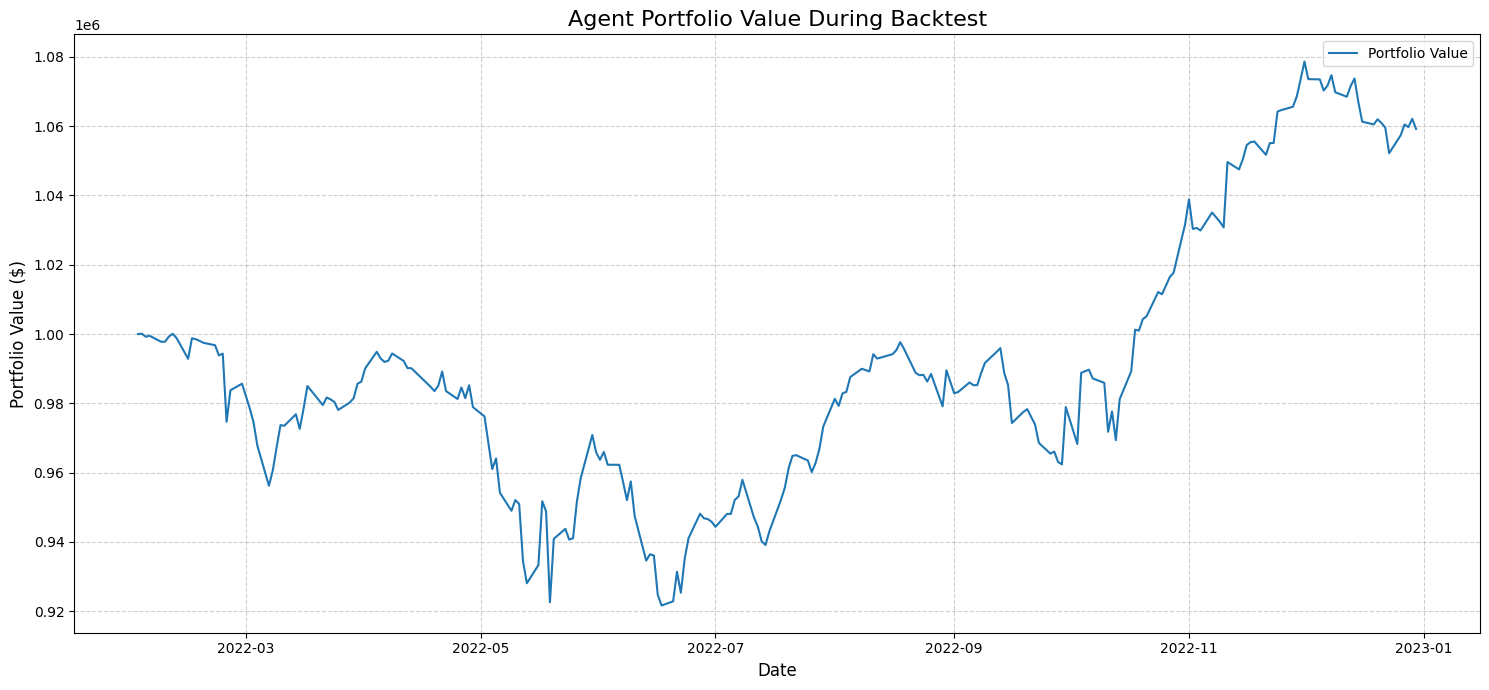

In [13]:
# <<<< REPLACE YOUR ENTIRE BACKTESTING CELL >>>>

import joblib

def load_and_backtest_a2c_model(actor_path, critic_path, tickers, start_date, end_date, initial_balance=1000000, transaction_fee=0.001):
    """
    Load a saved A2C model and its corresponding scaler, then run a backtest.
    This function ensures no data leakage during evaluation.
    """
    print("="*80)
    print("--- Starting Backtest Workflow ---")
    print("="*80)
    print(f"Loading model and running backtest from {start_date} to {end_date}")

    # === Step 1: Load Metadata and the SCALER ===
    print("\n[Step 1/4] Loading model metadata and data scaler...")
    metadata_path = actor_path.replace('_actor.weights.h5', '_metadata.json')
    try:
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        original_state_size = eval(metadata['state_size'])
        original_action_size = metadata['action_size']
        print(f"Loaded metadata. Original state_size: {original_state_size}, action_size: {original_action_size}")

        # --- LOAD THE SCALER ---
        scaler_path = os.path.join(os.path.dirname(actor_path), metadata['scaler_path'])
        scaler = joblib.load(scaler_path)
        print("Scaler loaded successfully.")
    except Exception as e:
        print(f"FATAL: Could not load metadata or scaler. {e}")
        return None

    # === Step 2: Fetch and Scale Backtesting Data ===
    print("\n[Step 2/4] Fetching and preparing backtest data...")
    backtest_dfs_raw = {}
    for ticker in tickers:
        df = fetch_stock_data(ticker, start_date, end_date)
        if df is not None:
            # Add indicators before scaling
            backtest_dfs_raw[ticker] = add_simple_indicators(df)

    if not backtest_dfs_raw:
        print("FATAL: No valid data for backtesting. Exiting.")
        return None

    # --- Apply the loaded scaler to the new data ---
    backtest_dfs_scaled = {ticker: df.copy() for ticker, df in backtest_dfs_raw.items() if df is not None}
    feature_cols = [col for col in next(iter(backtest_dfs_raw.values())).columns if col not in ['Open', 'High', 'Low', 'Close', 'Volume']]
    for ticker, df in backtest_dfs_scaled.items():
        # Important: Use scaler.transform(), NOT scaler.fit_transform()
        df[feature_cols] = scaler.transform(df[feature_cols])
    print("Backtest data has been scaled using the loaded scaler.")

    # === Step 3: Create Environment with Scaled Data ===
    print("\n[Step 3/4] Creating enhanced trading environment...")
    SentimentEnhancedEnv = SentimentEnhancedTradingEnv.enhance_environment(MultiStockTradingEnv)
    env = SentimentEnhancedEnv(
        stock_dfs=backtest_dfs_scaled,
        initial_balance=initial_balance,
        transaction_fee_percent=transaction_fee,
        window_size=original_state_size[0]
    )

    # === Step 4: Load Agent and Run Backtest ===
    print("\n[Step 4/4] Loading agent and running backtest...")
    best_params = metadata.get('best_params', {'actor_lr': 0.0002, 'critic_lr': 0.0004, 'gamma': 0.99})
    agent = A2CAgent(state_size=original_state_size, action_size=original_action_size, **best_params)
    agent.actor.load_weights(actor_path)
    agent.critic.load_weights(critic_path)
    print("Model weights loaded successfully.")

    backtest_results = run_backtest(env, agent) # Assuming run_backtest is defined
    return backtest_results

# --- Example Usage (to be placed in the same cell) ---
# Define paths to your saved model weights
# IMPORTANT: UPDATE these filenames to match the model you just saved
# For example:
# actor_path = 'saved_models/a2c_trading_model_20250613_112500_actor.weights.h5'
# critic_path = 'saved_models/a2c_trading_model_20250613_112500_critic.weights.h5'

# Find the latest saved model to run backtest on automatically
save_dir = 'saved_models'
model_files = [f for f in os.listdir(save_dir) if f.endswith('_actor.weights.h5')]
if model_files:
    latest_model_file = sorted(model_files)[-1]
    latest_model_base = latest_model_file.replace('_actor.weights.h5', '')
    actor_path = os.path.join(save_dir, latest_model_file)
    critic_path = os.path.join(save_dir, f"{latest_model_base}_critic.weights.h5")
    print(f"Found latest model: {latest_model_base}")

    if os.path.exists(actor_path) and os.path.exists(critic_path):
        backtest_run_results = load_and_backtest_a2c_model(
            actor_path=actor_path,
            critic_path=critic_path,
            tickers=stocks,
            start_date=testing_period[0],
            end_date=testing_period[1],
            initial_balance=1000000,
            transaction_fee=0.001
        )
    else:
        print(f"Error: Model files not found. Please check the paths and filenames.")
else:
    print("No saved models found in 'saved_models' directory to backtest.")